Эксперименты к исследованию градиентного и стохастического градиентного спуска

Выполнил: Авдеев Роман 317

# Imports + Data Prepare

In [209]:
import numpy as np
import scipy as sc
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from utils import grad_finite_diff
from oracles import BinaryLogistic
from optimization import GDClassifier, SGDClassifier
import matplotlib
import matplotlib.pyplot as plt
# import seaborn as sns
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
from heapq import nlargest
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [231]:
data_train = pd.read_csv(r'C:\Users\Авдеев\Desktop\ноутбуки прак и ммро\прак\logistic_regression\data_toxic\toxic_train.csv')
data_test = pd.read_csv(r"C:\Users\Авдеев\Desktop\ноутбуки прак и ммро\прак\logistic_regression\data_toxic\toxic_test.csv")

In [198]:
data_train

,Unnamed: 0,comment_text,is_toxic
0,0,Explanation\nWhy the edits made under my usern...,False
1,1,D'aww! He matches this background colour I'm s...,False
2,2,"Hey man, I'm really not trying to edit war. It...",False
3,3,"""\nMore\nI can't make any real suggestions on ...",False
4,4,"You, sir, are my hero. Any chance you remember...",False
...,...,...,...
52056,159494,"""\n\n our previous conversation \n\nyou fuckin...",True
52057,159514,YOU ARE A MISCHIEVIOUS PUBIC HAIR,True
52058,159541,Your absurd edits \n\nYour absurd edits on gre...,True
52059,159546,"""\n\nHey listen don't you ever!!!! Delete my e...",True


In [199]:
data_test

,Unnamed: 0,comment_text,is_toxic
0,0,Thank you for understanding. I think very high...,False
1,1,:Dear god this site is horrible.,False
2,2,"""::: Somebody will invariably try to add Relig...",False
3,3,""" \n\n It says it right there that it IS a typ...",False
4,4,""" \n\n == Before adding a new product to the l...",False
...,...,...,...
20671,63877,NIGEL IS A CRAZY IDIOT!!!,True
20672,63935,""" \n ::Well, now don't I feel stupid.... · """,True
20673,63945,==Fourth Baldrick possibly being cleverer than...,True
20674,63962,""" \n\n == IRAN == \n That’s right, Iran. It wa...",True


In [200]:
print('Количество объектов в обучающей выборке: ', data_train.shape[0])
print('Количество объектов в тестовой выборке: ', data_test.shape[0])

Количество объектов в обучающей выборке:  52061
Количество объектов в тестовой выборке:  20676


# Experiment 1

In [232]:
def clear_text(text):
    document = re.sub(r'[\W_]+', ' ', text)    
    document = re.sub(r'\s+', ' ', document, flags=re.I)  
    document = re.sub(r'^b\s+', '', document)
    document = document.lower()
    document = document.strip()
    return document

In [233]:
temp = pd.Series(data_train['comment_text'].values.astype('U'))
corpus = temp.apply(clear_text)
data_train['comment_text'] = corpus

In [234]:
temp = pd.Series(data_test['comment_text'].values.astype('U'))
corpus = temp.apply(clear_text)
data_test['comment_text'] = corpus

# Experiment 2

In [10]:
vectorizer  = CountVectorizer(min_df=0.15, max_df=0.8)
cv_train = vectorizer.fit_transform(data_train['comment_text']).toarray()
cv_test = vectorizer.fit_transform(data_test['comment_text']).toarray()

In [235]:
data_train['is_toxic'].replace({False: -1, True: 1}, inplace=True)
data_test['is_toxic'].replace({False: -1, True: 1}, inplace=True)

# Experiment 3

In [74]:
np.random.seed(1693)
l2_coef = np.random.randint(0, 10)
l, d = 10000, 5000
my_oracle = BinaryLogistic(l2_coef=l2_coef)

X = np.random.random((l, d))
y = np.random.choice([-1, 1], 10000)
w = np.random.random(d)

res_grad = my_oracle.grad(X, y, w)
print(res_grad)

res_utils = grad_finite_diff(my_oracle.func, w, X=X, y=y, eps=1e-3)
print(res_utils)

[0.25168715 0.25565321 0.25380223 ... 0.24820058 0.2534742  0.24913435]
[0.25168715 0.25565321 0.25380223 ... 0.24820058 0.2534742  0.24913435]


In [75]:
res_difference = res_grad - res_utils
print(res_difference)
print('Среднее расхождение среди признаков: ', np.mean(res_difference))

[ 4.02194944e-11  6.75960954e-11 -6.57893184e-11 ...  1.15880777e-10
 -1.61436420e-11  1.97790118e-11]
Среднее расхождение среди признаков:  1.0704334796329818e-11


# Experiment 4

In [14]:
X_train = cv_train
y_train = np.array(data_train['is_toxic'])
X_test = cv_test
y_test = np.array(data_test['is_toxic'])

In [15]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=10)

## w_0

### const

In [369]:
weights_list = np.arange(-1, 1.1, 0.1)

In [370]:
history_time_w = {}
history_func_w = {}
history_weights_w = {}

In [371]:
for w in weights_list:
    history_weights_w[round(w, 1)] = []
    history_time_w[round(w, 1)] = []
    history_func_w[round(w, 1)] = []

In [372]:
for weight in weights_list:
    gd = GDClassifier('binary_logistic', l2_coef=0, max_iter=500, step_alpha=1.08, step_beta=0.58)
    w = np.full(shape=X_train.shape[1], fill_value=weight, dtype=float)
        
    history = gd.fit(X_train, y_train, w_0=w, trace=True)
    history_time_w[round(weight, 1)] = history['time']
    history_func_w[round(weight, 1)] = history['func']
    history_weights_w[round(weight, 1)] = history['weights']

#### accuracy

In [373]:
accuracy_results_w = {}
for weight in weights_list:
    accuracy_results_w[round(weight, 1)] = []

In [374]:
for weight in weights_list:
    for weights in history_weights_w[round(weight, 1)]:
        y_pred = np.sign(X_valid @ weights)
        accuracy = accuracy_score(y_valid, y_pred)
        accuracy_results_w[round(weight, 1)].append(accuracy)

In [375]:
mean_accuracy_results_w = {}
for weight in weights_list:
    mean_accuracy_results_w[round(weight, 1)] = []
    
for weight in weights_list:
    mean_acc = np.mean(accuracy_results_w[round(weight, 1)])
    mean_accuracy_results_w[round(weight, 1)] = mean_acc

In [376]:
mean_accuracy_results_w_list = []
for key, value in mean_accuracy_results_w.items():
    mean_accuracy_results_w_list.append([key, value])

In [377]:
mean_accuracy_results_w_list

[[-1.0, 0.7081192739844425],
 [-0.9, 0.7117770095073466],
 [-0.8, 0.7167335061941803],
 [-0.7, 0.7214430039373859],
 [-0.6, 0.7271491404974552],
 [-0.5, 0.7307973549546584],
 [-0.4, 0.7338136212801396],
 [-0.3, 0.737350256967872],
 [-0.2, 0.7382855075666246],
 [-0.1, 0.7395113079804091],
 [-0.0, 0.7442931706832601],
 [0.1, 0.739408379857818],
 [0.2, 0.7371874899964789],
 [0.3, 0.7341561261822226],
 [0.4, 0.7296129837702872],
 [0.5, 0.7237549217324498],
 [0.6, 0.7174034380101796],
 [0.7, 0.7111257082493038],
 [0.8, 0.7045877268798617],
 [0.9, 0.6967751848650725],
 [1.0, 0.6881167771055411]]

In [378]:
mean_weights = list(mean_accuracy_results_w.values())

In [379]:
best_weights_ind = sorted(range(len(mean_weights)), key=lambda x: mean_weights[x])[-5:]

In [380]:
best_weights = list(map(lambda x: mean_accuracy_results_w_list[x], best_weights_ind))
best_weights

[[-0.3, 0.737350256967872],
 [-0.2, 0.7382855075666246],
 [0.1, 0.739408379857818],
 [-0.1, 0.7395113079804091],
 [-0.0, 0.7442931706832601]]

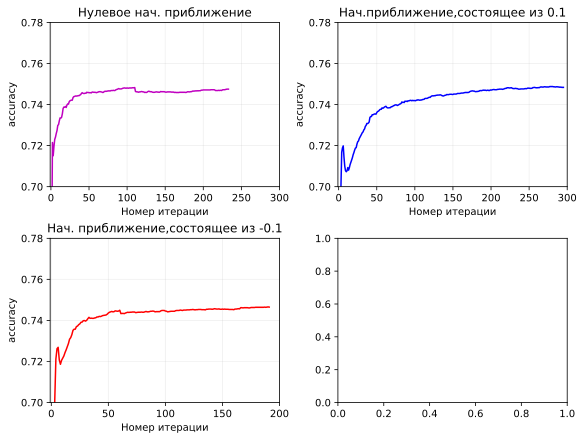

In [391]:
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 6), constrained_layout=True)

ax[0, 0].set_xlabel('Номер итерации')
ax[0, 0].set_ylabel('accuracy')
ax[0, 0].set_title('Нулевое нач. приближение')
ax[0, 0].plot(np.arange(0, 234, step=1), accuracy_results_w[0.0], 'm', label='weight = 0.0')
ax[0, 0].set_xlim((-1, 300))
ax[0, 0].set_ylim((0.7, 0.78))
ax[0, 0].grid(linestyle="-", alpha=.2)

ax[1, 0].set_xlabel('Номер итерации')
ax[1, 0].set_ylabel('accuracy')
ax[1, 0].set_title('Нач. приближение,состоящее из -0.1')
ax[1, 0].plot(np.arange(0, 192, step=1), accuracy_results_w[-0.1], 'r', label='weight = -0.1')
ax[1, 0].set_xlim((-1, 200))
ax[1, 0].set_ylim((0.7, 0.78))
ax[1, 0].grid(linestyle="-", alpha=.2)

ax[0, 1].set_xlabel('Номер итерации')
ax[0, 1].set_ylabel('accuracy')
ax[0, 1].set_title('Нач.приближение,состоящее из 0.1')
ax[0, 1].plot(np.arange(0, 296, step=1), accuracy_results_w[0.1], 'b', label='weight = 0.1')
ax[0, 1].set_xlim((-1, 300))
ax[0, 1].set_ylim((0.7, 0.78))
ax[0, 1].grid(linestyle="-", alpha=.2)
plt.show()

#### loss

In [392]:
min_loss_results_w = {}
for weight in weights_list:
    min_loss_results_w[round(weight, 1)] = []

for weight in weights_list:
    min_loss = np.min(history_func_w[round(weight, 1)])
    min_loss_results_w[round(weight, 1)] = min_loss

In [393]:
min_loss_results_w

{-1.0: 0.579636945601,
 -0.9: 0.570773820281,
 -0.8: 0.564150770217,
 -0.7: 0.559845280468,
 -0.6: 0.556969012105,
 -0.5: 0.555854698549,
 -0.4: 0.555341558812,
 -0.3: 0.555064344186,
 -0.2: 0.555025685226,
 -0.1: 0.555236358764,
 -0.0: 0.555731463713,
 0.1: 0.556196266384,
 0.2: 0.556721650255,
 0.3: 0.557209627002,
 0.4: 0.558187467868,
 0.5: 0.559692153512,
 0.6: 0.561475976143,
 0.7: 0.563656874536,
 0.8: 0.5664491796,
 0.9: 0.570522619519,
 1.0: 0.576579218231}

In [394]:
min_loss_results_w_list = []
for key, value in min_loss_results_w.items():
    min_loss_results_w_list.append([key, value])

In [395]:
min_loss_w = list(min_loss_results_w.values())
best_weights_ind = sorted(range(len(min_loss_w)), key=lambda x: min_loss_w[x])[:5]
best_weights_ind

[8, 7, 9, 6, 10]

In [396]:
best_weights = list(map(lambda x: min_loss_results_w_list[x], best_weights_ind))
best_weights

[[-0.2, 0.555025685226],
 [-0.3, 0.555064344186],
 [-0.1, 0.555236358764],
 [-0.4, 0.555341558812],
 [-0.0, 0.555731463713]]

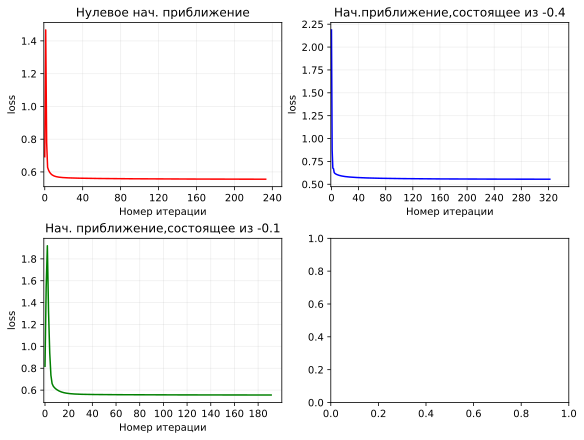

In [415]:
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 6), constrained_layout=True)

ax[0, 0].set_xlabel('Номер итерации')
ax[0, 0].set_ylabel('loss')
ax[0, 0].set_title('Нулевое нач. приближение')
ax[0, 0].plot(np.arange(0, 234, step=1), history_func_w[0.0], 'r', label='weight = 0.0')
ax[0, 0].set_xlim((-1, 250))
ax[0, 0].set_xticks(np.arange(0, 250, step=40), rotate=30)
ax[0, 0].grid(linestyle="-", alpha=.2)

ax[1, 0].set_xlabel('Номер итерации')
ax[1, 0].set_ylabel('loss')
ax[1, 0].set_title('Нач. приближение,состоящее из -0.1')
ax[1, 0].plot(np.arange(0, 192, step=1), history_func_w[-0.1], 'g', label='weight = -0.1')
ax[1, 0].set_xlim((-1, 200))
ax[1, 0].grid(linestyle="-", alpha=.2)
ax[1, 0].set_xticks(np.arange(0, 200, step=20), rotate=30)

ax[0, 1].set_xlabel('Номер итерации')
ax[0, 1].set_ylabel('loss')
ax[0, 1].set_title('Нач.приближение,состоящее из -0.4')
ax[0, 1].plot(np.arange(0, 323, step=1), history_func_w[-0.4], 'b', label='weight = -0.4')
ax[0, 1].set_xlim((-1, 350))
ax[0, 1].grid(linestyle="-", alpha=.2)
ax[0, 1].set_xticks(np.arange(0, 350, step=40))
plt.show()

### random

## alpha & beta

In [12]:
alphas = np.arange(1, 4, 0.08)
betas = np.arange(0.1, 0.6, 0.08)

In [278]:
for alpha in alphas:
    alpha = round(alpha, 2)
for beta in betas:
    beta = round(beta, 2)

In [279]:
accuracy_results = {}
for alpha in alphas:
    accuracy_results[round(alpha, 2)] = {}
    for beta in betas:
        accuracy_results[round(alpha, 2)][round(beta, 2)] = []

In [280]:
history_time = {}
history_func = {}
history_weights = {}

In [281]:
for alpha in alphas:
    history_weights[round(alpha, 2)]= {}
    history_time[round(alpha, 2)] = {}
    history_func[round(alpha, 2)] = {}
    for beta in betas:
        history_weights[round(alpha, 2)][round(beta, 2)] = []
        history_time[round(alpha, 2)][round(beta, 2)] = []
        history_func[round(alpha, 2)][round(beta, 2)] = []

In [283]:
w = np.zeros(X_train.shape[1])

for alpha in alphas:
    for beta in betas:
        gd = GDClassifier('binary_logistic', step_alpha=alpha, step_beta=beta,
                          l2_coef=0, max_iter=500)
        
        history = gd.fit(X_train, y_train, w_0=w, trace=True)
        history_time[round(alpha, 2)][round(beta, 2)] = history['time']
        history_func[round(alpha, 2)][round(beta, 2)] = history['func']
        history_weights[round(alpha, 2)][round(beta, 2)] = history['weights']

### accuracy

In [284]:
for alpha in alphas:
    for beta in betas:
        for weights in history_weights[round(alpha, 2)][round(beta, 2)]:
            y_pred = np.sign(X_valid @ weights)
            accuracy = accuracy_score(y_valid, y_pred)
            accuracy_results[round(alpha, 2)][round(beta, 2)].append(accuracy)

In [285]:
mean_accuracy_results = {}
for alpha in alphas:
    mean_accuracy_results[round(alpha, 2)]= {}
    for beta in betas:
        mean_accuracy_results[round(alpha, 2)][round(beta, 2)] = []

In [286]:
for alpha in alphas:
    for beta in betas:
        mean_acc = np.mean(accuracy_results[round(alpha, 2)][round(beta, 2)])
        mean_accuracy_results[round(alpha, 2)][round(beta, 2)] = mean_acc

In [287]:
mean_accuracy_results

{1.0: {0.1: 0.7331556209515854,
  0.18: 0.7335481506966179,
  0.26: 0.7391111438668273,
  0.34: 0.7407197397178074,
  0.42: 0.7413084299290371,
  0.5: 0.741611273412585,
  0.58: 0.7415865324353209},
 1.08: {0.1: 0.7327892058004418,
  0.18: 0.7300307813613548,
  0.26: 0.7375572201414897,
  0.34: 0.7403206745100807,
  0.42: 0.7411054145604706,
  0.5: 0.7413489548321011,
  0.58: 0.7414490926447135},
 1.16: {0.1: 0.7260186305579563,
  0.18: 0.7159131161709904,
  0.26: 0.7361496961216062,
  0.34: 0.7397998878213827,
  0.42: 0.7408065093458351,
  0.5: 0.7410751353707273,
  0.58: 0.7413031830643297},
 1.24: {0.1: 0.7206561029482377,
  0.18: 0.7251780318979973,
  0.26: 0.734243068944884,
  0.34: 0.7391470720770634,
  0.42: 0.7405049654401425,
  0.5: 0.740789105591255,
  0.58: 0.7411477411477411},
 1.32: {0.1: 0.716956304619226,
  0.18: 0.7228362436675054,
  0.26: 0.7319953943375697,
  0.34: 0.7380811816251124,
  0.42: 0.7401175009521719,
  0.5: 0.7405630230116863,
  0.58: 0.740875702820257},
 

In [288]:
best_betas_for_each_alpha = []
best_acc_list = []

for alpha in alphas:
    curr_best_beta = max(mean_accuracy_results[round(alpha, 2)], key=mean_accuracy_results[round(alpha, 2)].get)
    best_betas_for_each_alpha.append([round(alpha, 2), curr_best_beta, mean_accuracy_results[round(alpha, 2)][curr_best_beta]])
    best_acc_list.append(mean_accuracy_results[round(alpha, 2)][curr_best_beta])

In [289]:
best_betas_for_each_alpha

[[1.0, 0.5, 0.741611273412585],
 [1.08, 0.58, 0.7414490926447135],
 [1.16, 0.58, 0.7413031830643297],
 [1.24, 0.58, 0.7411477411477411],
 [1.32, 0.58, 0.740875702820257],
 [1.4, 0.58, 0.7406106632074174],
 [1.48, 0.58, 0.7403616128743241],
 [1.56, 0.58, 0.7401050081909535],
 [1.64, 0.58, 0.7397146017620425],
 [1.72, 0.58, 0.7393772672496848],
 [1.8, 0.58, 0.7391021098886268],
 [1.88, 0.58, 0.7387894059835821],
 [1.96, 0.58, 0.7384604086520807],
 [2.04, 0.58, 0.7380914389557431],
 [2.12, 0.58, 0.7377854604820896],
 [2.2, 0.58, 0.7373851595761707],
 [2.28, 0.58, 0.737027712015499],
 [2.36, 0.58, 0.7367177030098377],
 [2.44, 0.58, 0.7363854132729487],
 [2.52, 0.58, 0.7358818653680657],
 [2.6, 0.58, 0.7354055294130198],
 [2.68, 0.58, 0.7350527385639746],
 [2.76, 0.58, 0.7347019699321254],
 [2.84, 0.58, 0.7342264477095937],
 [2.92, 0.58, 0.7337611804872558],
 [3.0, 0.58, 0.7332695394493148],
 [3.08, 0.58, 0.7329393605085576],
 [3.16, 0.58, 0.7325506578315567],
 [3.24, 0.58, 0.73208415516107

In [290]:
best_acc_indexes = sorted(range(len(best_acc_list)), key=lambda x: best_acc_list[x])[-5:]

In [291]:
best_acc_indexes

[4, 3, 2, 1, 0]

In [293]:
best_cominations = list(map(lambda x: best_betas_for_each_alpha[x], best_acc_indexes))
best_cominations

[[1.32, 0.58, 0.740875702820257],
 [1.24, 0.58, 0.7411477411477411],
 [1.16, 0.58, 0.7413031830643297],
 [1.08, 0.58, 0.7414490926447135],
 [1.0, 0.5, 0.741611273412585]]

Случай выбора по лучшему среднему значению

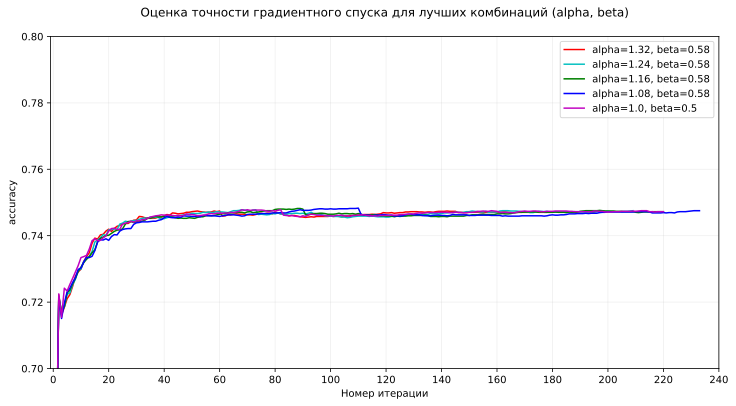

In [301]:
plt.figure(figsize=(12, 6))
plt.title('Оценка точности градиентного спуска для лучших комбинаций (alpha, beta)', pad=20)
plt.xlabel('Номер итерации')
plt.ylabel('accuracy')

plt.plot(np.arange(0, 199, step=1), accuracy_results[1.32][0.58], 'r', label='alpha=1.32, beta=0.58')
plt.plot(np.arange(0, 210, step=1), accuracy_results[1.24][0.58], 'c', label='alpha=1.24, beta=0.58')
plt.plot(np.arange(0, 221, step=1), accuracy_results[1.16][0.58], 'g', label='alpha=1.16, beta=0.58')
plt.plot(np.arange(0, 234, step=1), accuracy_results[1.08][0.58], 'b', label='alpha=1.08, beta=0.58')
plt.plot(np.arange(0, 221, step=1), accuracy_results[1.0][0.5], 'm', label='alpha=1.0, beta=0.5')
plt.legend(loc='best')
plt.xticks(np.arange(0, 500, step=20))
plt.grid(linestyle="-", alpha=.2)
plt.ylim((0.7, 0.8))
plt.xlim((-1, 240))
plt.show()

Случай выбор по максимальному значению точности

In [302]:
max_accuracy_results = {}
for alpha in alphas:
    max_accuracy_results[round(alpha, 2)] = {}
    for beta in betas:
        max_accuracy_results[round(alpha, 2)][round(beta, 2)] = []

In [303]:
for alpha in alphas:
    for beta in betas:
        max_acc = np.max(accuracy_results[round(alpha, 2)][round(beta, 2)])
        max_accuracy_results[round(alpha, 2)][round(beta, 2)] = max_acc

In [304]:
best_betas_for_each_alpha = []
best_acc_list = []

for alpha in alphas:
    curr_best_beta = max(max_accuracy_results[round(alpha, 2)], key=max_accuracy_results[round(alpha, 2)].get)
    best_betas_for_each_alpha.append([round(alpha, 2), curr_best_beta, max_accuracy_results[round(alpha, 2)][curr_best_beta]])
    best_acc_list.append(max_accuracy_results[round(alpha, 2)][curr_best_beta])

In [305]:
best_acc_indexes = sorted(range(len(best_acc_list)), key=lambda x: best_acc_list[x])[-5:]
best_cominations = list(map(lambda x: best_betas_for_each_alpha[x], best_acc_indexes))
best_cominations

[[3.88, 0.34, 0.7518486507250552],
 [3.96, 0.58, 0.7519446845289542],
 [3.08, 0.5, 0.7520407183328531],
 [3.8, 0.58, 0.7520407183328531],
 [3.0, 0.5, 0.7523288197445501]]

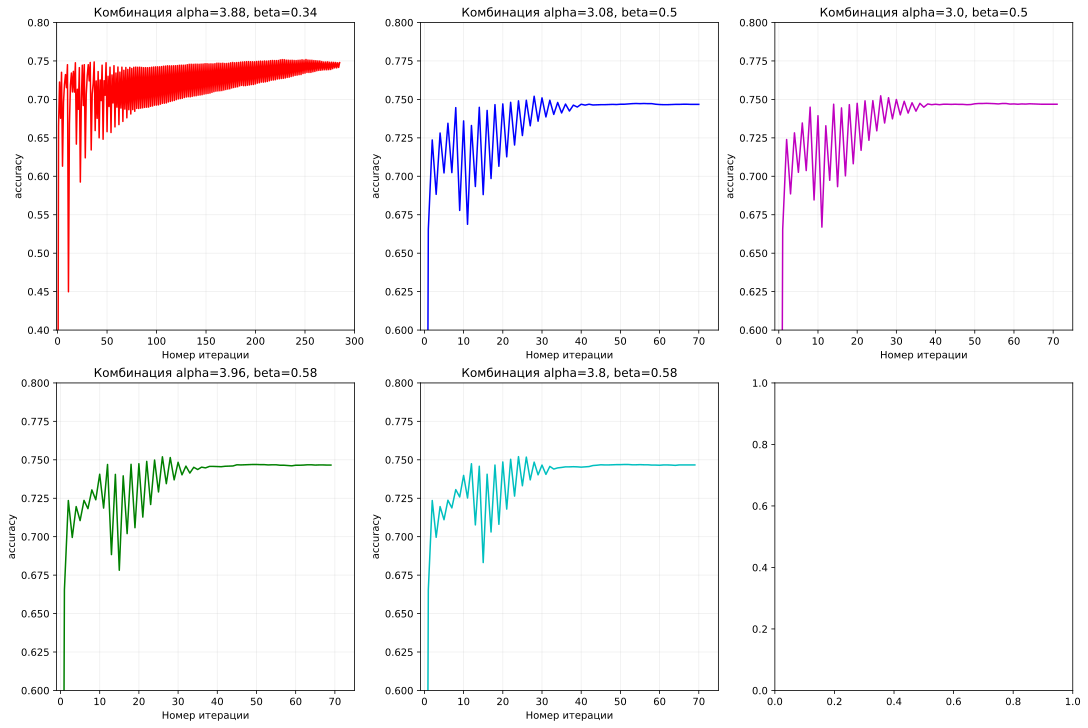

In [389]:
f, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10), constrained_layout=True)

ax[0, 0].set_xlabel('Номер итерации')
ax[0, 0].set_ylabel('accuracy')
ax[0, 0].set_title('Комбинация alpha=3.88, beta=0.34')
ax[0, 0].plot(np.arange(0, 286, step=1), accuracy_results[3.88][0.34], 'r', label='alpha=3.88, beta=0.34')
ax[0, 0].set_xlim((-1, 300))
ax[0, 0].set_ylim((0.4, 0.8))
ax[0, 0].grid(linestyle="-", alpha=.2)

ax[1, 0].set_xlabel('Номер итерации')
ax[1, 0].set_ylabel('accuracy')
ax[1, 0].set_title('Комбинация alpha=3.96, beta=0.58')
ax[1, 0].plot(np.arange(0, 70, step=1), accuracy_results[3.96][0.58], 'g', label='alpha=3.96, beta=0.58')
ax[1, 0].set_xlim((-1, 75))
ax[1, 0].set_ylim((0.6, 0.8))
ax[1, 0].grid(linestyle="-", alpha=.2)

ax[0, 1].set_xlabel('Номер итерации')
ax[0, 1].set_ylabel('accuracy')
ax[0, 1].set_title('Комбинация alpha=3.08, beta=0.5')
ax[0, 1].plot(np.arange(0, 71, step=1), accuracy_results[3.08][0.5], 'b', label='alpha=3.08, beta=0.5')
ax[0, 1].set_xlim((-1, 75))
ax[0, 1].set_ylim((0.6, 0.8))
ax[0, 1].grid(linestyle="-", alpha=.2)

ax[1, 1].set_xlabel('Номер итерации')
ax[1, 1].set_ylabel('accuracy')
ax[1, 1].set_title('Комбинация alpha=3.8, beta=0.58')
ax[1, 1].plot(np.arange(0, 70, step=1), accuracy_results[3.8][0.58], 'c', label='alpha=3.8, beta=0.58')
ax[1, 1].set_xlim((-1, 75))
ax[1, 1].set_ylim((0.6, 0.8))
ax[1, 1].grid(linestyle="-", alpha=.2)

ax[0, 2].set_xlabel('Номер итерации')
ax[0, 2].set_ylabel('accuracy')
ax[0, 2].set_title('Комбинация alpha=3.0, beta=0.5')
ax[0, 2].plot(np.arange(0, 72, step=1), accuracy_results[3.0][0.5], 'm', label='alpha=3.3, beta=0.5')
ax[0, 2].set_xlim((-1, 75))
ax[0, 2].set_ylim((0.6, 0.8))
ax[0, 2].grid(linestyle="-", alpha=.2)
plt.show()

### loss

С наименьшим loss

In [326]:
min_loss_results = {}
for alpha in alphas:
    min_loss_results[round(alpha, 2)] = {}
    for beta in betas:
        min_loss_results[round(alpha, 2)][round(beta, 2)] = []

In [327]:
for alpha in alphas:
    for beta in betas:
        min_loss = np.min(history_func[round(alpha, 2)][round(beta, 2)])
        min_loss_results[round(alpha, 2)][round(beta, 2)] = min_loss

In [328]:
best_betas_for_each_alpha = []
best_loss_list = []

for alpha in alphas:
    curr_best_beta = min(min_loss_results[round(alpha, 2)], key=min_loss_results[round(alpha, 2)].get)
    best_betas_for_each_alpha.append([round(alpha, 2), curr_best_beta, min_loss_results[round(alpha, 2)][curr_best_beta]])
    best_loss_list.append(min_loss_results[round(alpha, 2)][curr_best_beta])

In [329]:
best_loss_indexes = sorted(range(len(best_loss_list)), key=lambda x: best_loss_list[x])[:5]
best_loss_indexes

[12, 27, 23, 10, 22]

In [330]:
best_cominations = list(map(lambda x: best_betas_for_each_alpha[x], best_loss_indexes))
best_cominations

[[1.96, 0.26, 0.552825315395],
 [3.16, 0.34, 0.552846568661],
 [2.84, 0.34, 0.552853693911],
 [1.8, 0.26, 0.552859457967],
 [2.76, 0.34, 0.552865431371]]

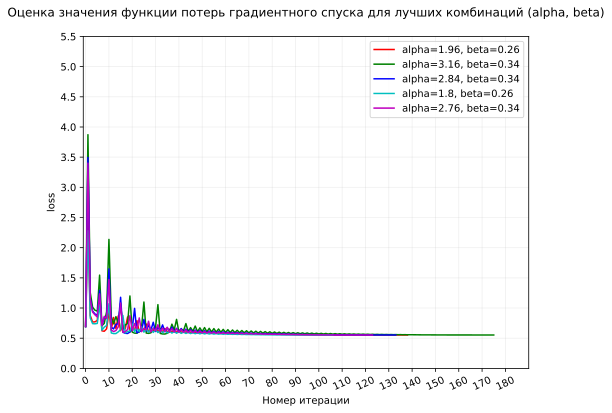

In [343]:
plt.figure(figsize=(8, 6))
plt.title('Оценка значения функции потерь градиентного спуска для лучших комбинаций (alpha, beta)', pad=20)
plt.xlabel('Номер итерации')
plt.ylabel('loss')

plt.plot(np.arange(0, 139, step=1), history_func[1.96][0.26], 'r', label='alpha=1.96, beta=0.26')
plt.plot(np.arange(0, 176, step=1), history_func[3.16][0.34], 'g', label='alpha=3.16, beta=0.34')
plt.plot(np.arange(0, 134, step=1), history_func[2.84][0.34], 'b', label='alpha=2.84, beta=0.34')
plt.plot(np.arange(0, 107, step=1), history_func[1.8][0.26], 'c', label='alpha=1.8, beta=0.26')
plt.plot(np.arange(0, 124, step=1), history_func[2.76][0.34], 'm', label='alpha=2.76, beta=0.34')
plt.legend(loc='best')
plt.xticks(np.arange(0, 190, step=10), rotation=25)
plt.yticks(np.arange(0, 13, step=0.5))
plt.grid(linestyle="-", alpha=.2)
plt.ylim((0.0, 5.5))
plt.xlim((-1, 190))
plt.show()

# Experiment 5 + Experiment 6

## batch_size

In [185]:
batch_list = [100, 400, 600]

In [186]:
history_time_b = {}
history_func_b = {}
history_weights_b = {}
for b in batch_list:
    history_weights_b[b] = []
    history_time_b[b] = []
    history_func_b[b] = []

In [187]:
w = np.full(shape=X_train.shape[1], fill_value=0.0, dtype=float)

for batch in batch_list:
    sgd = SGDClassifier('binary_logistic', step_alpha=1.0, step_beta=0.34,
                          l2_coef=0, max_iter=500, batch_size=batch)
        
    history = sgd.fit(X_train, y_train, w_0=w, trace=True, log_freq=0.1)
    history_time_b[batch] = history['time']
    history_func_b[batch] = history['func']
    history_weights_b[batch] = history['weights']

### accuracy

In [188]:
accuracy_results_b = {}
for batch in batch_list:
    accuracy_results_b[batch] = []
for batch in batch_list:
    for weights in history_weights_b[batch]:
        y_pred = np.sign(X_valid @ weights)
        accuracy = accuracy_score(y_valid, y_pred)
        accuracy_results_b[batch] .append(accuracy)

In [189]:
mean_accuracy_results_b = {}
for batch in batch_list:
    mean_accuracy_results_b[batch] = []

In [190]:
for batch in batch_list:
    mean_acc = np.mean(accuracy_results_b[batch])
    mean_accuracy_results_b[batch] = mean_acc

In [191]:
mean_accuracy_results_b_list = []
for key, value in mean_accuracy_results_b.items():
    mean_accuracy_results_b_list.append([key, value])
mean_accuracy_results_b_list

[[100, 0.7315562904229246],
 [400, 0.7380788806890795],
 [600, 0.742473350619418]]

In [192]:
mean_weights = list(mean_accuracy_results_b.values())
best_weights_ind = sorted(range(len(mean_weights)), key=lambda x: mean_weights[x])[-5:]
best_weights = list(map(lambda x: mean_accuracy_results_b_list[x], best_weights_ind))
best_weights

[[100, 0.7315562904229246],
 [400, 0.7380788806890795],
 [600, 0.742473350619418]]

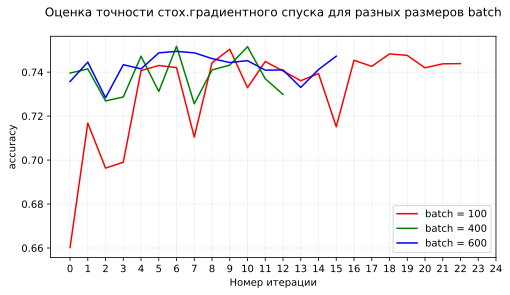

In [194]:
plt.figure(figsize=(8, 4))
plt.title('Оценка точности стох.градиентного спуска для разных размеров batch', pad=20)
plt.xlabel('Номер итерации')
plt.ylabel('accuracy')


plt.plot(np.arange(0, 23, step=1), accuracy_results_b[100], 'r', label='batch = 100')
plt.plot(np.arange(0, 13, step=1), accuracy_results_b[400], 'g', label='batch = 400')
plt.plot(np.arange(0, 16, step=1), accuracy_results_b[600], 'b', label='batch = 600')
plt.xticks(np.arange(0, 25, step=1))
plt.grid(linestyle="-", alpha=.2)
plt.legend(loc='best')
plt.show()

### loss

In [195]:
min_loss_results_b = {}
for batch in batch_list:
    min_loss_results_b[batch] = []

In [196]:
for batch in batch_list:
    min_loss = np.min(history_func_b[batch])
    min_loss_results_b[batch] = min_loss

In [197]:
min_loss_results_b
min_loss_results_b_list = []
for key, value in min_loss_results_b.items():
    min_loss_results_b_list.append([key, value])

In [202]:
min_loss_b = list(min_loss_results_b.values())
best_weights_ind = sorted(range(len(min_loss_b)), key=lambda x: min_loss_b[x])[:5]
best_weights_ind
best_weights = list(map(lambda x: min_loss_results_b_list[x], best_weights_ind))
best_weights

[[100, 0.55581778617], [600, 0.556767301659], [400, 0.557338646421]]

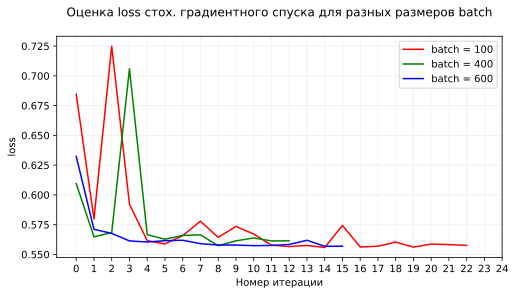

In [206]:

plt.figure(figsize=(8, 4))
plt.title('Оценка loss стох. градиентного спуска для разных размеров batch', pad=20)
plt.xlabel('Номер итерации')
plt.ylabel('loss')


plt.plot(np.arange(0, 23, step=1), history_func_b[100], 'r', label='batch = 100')
plt.plot(np.arange(0, 13, step=1), history_func_b[400], 'g', label='batch = 400')
plt.plot(np.arange(0, 16, step=1), history_func_b[600], 'b', label='batch = 600')
plt.xticks(np.arange(0, 25, step=1))
plt.grid(linestyle="-", alpha=.2)
plt.legend(loc='best')
plt.show()

## w_0

### const

In [86]:
weights_list = np.arange(-1, 1.1, 0.1)
history_time_w = {}
history_func_w = {}
history_weights_w = {}
for w in weights_list:
    history_weights_w[round(w, 1)] = []
    history_time_w[round(w, 1)] = []
    history_func_w[round(w, 1)] = []

In [88]:
for weight in weights_list:
    sgd = SGDClassifier('binary_logistic', step_alpha=1.0, step_beta=0.34,
                          l2_coef=0, max_iter=500, batch_size=100)
    w = np.full(shape=X_train.shape[1], fill_value=weight, dtype=float)
        
    history = sgd.fit(X_train, y_train, w_0=w, trace=True, log_freq=0.1)
    history_time_w[round(weight, 1)] = history['time']
    history_func_w[round(weight, 1)] = history['func']
    history_weights_w[round(weight, 1)] = history['weights']

#### accuracy

In [94]:
accuracy_results_w = {}
for weight in weights_list:
    accuracy_results_w[round(weight, 1)] = []
for weight in weights_list:
    for weights in history_weights_w[round(weight, 1)]:
        y_pred = np.sign(X_valid @ weights)
        accuracy = accuracy_score(y_valid, y_pred)
        accuracy_results_w[round(weight, 1)].append(accuracy)

In [96]:
mean_accuracy_results_w = {}
for weight in weights_list:
    mean_accuracy_results_w[round(weight, 1)] = []

In [97]:
for weight in weights_list:
    mean_acc = np.mean(accuracy_results_w[round(weight, 1)])
    mean_accuracy_results_w[round(weight, 1)] = mean_acc

In [98]:
mean_accuracy_results_w_list = []
for key, value in mean_accuracy_results_w.items():
    mean_accuracy_results_w_list.append([key, value])
mean_accuracy_results_w_list

[[-1.0, 0.716689608075376],
 [-0.9, 0.7152277601715804],
 [-0.8, 0.6697397483914338],
 [-0.7, 0.7250744261980218],
 [-0.6, 0.7094257178526842],
 [-0.5, 0.7277005142173681],
 [-0.4, 0.7241771960873084],
 [-0.3, 0.7178664032596618],
 [-0.2, 0.6980697205416306],
 [-0.1, 0.7151997503121099],
 [-0.0, 0.7315562904229246],
 [0.1, 0.7137918261513768],
 [0.2, 0.7124336337819484],
 [0.3, 0.7108833738047221],
 [0.4, 0.7181931676313699],
 [0.5, 0.6963411120714491],
 [0.6, 0.7142754249495822],
 [0.7, 0.7228144306795993],
 [0.8, 0.7097721255024625],
 [0.9, 0.7159992317295688],
 [1.0, 0.651301258042831]]

In [99]:
mean_weights = list(mean_accuracy_results_w.values())
best_weights_ind = sorted(range(len(mean_weights)), key=lambda x: mean_weights[x])[-5:]
best_weights = list(map(lambda x: mean_accuracy_results_w_list[x], best_weights_ind))
best_weights

[[0.7, 0.7228144306795993],
 [-0.4, 0.7241771960873084],
 [-0.7, 0.7250744261980218],
 [-0.5, 0.7277005142173681],
 [-0.0, 0.7315562904229246]]

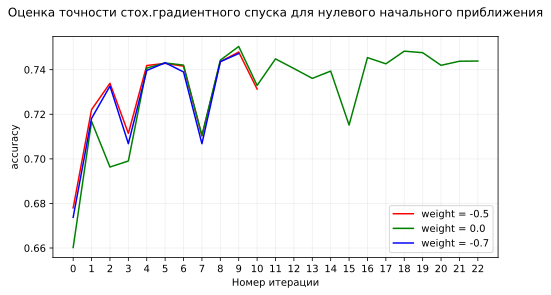

In [116]:
plt.figure(figsize=(8, 4))
plt.title('Оценка точности стох.градиентного спуска для нулевого начального приближения', pad=20)
plt.xlabel('Номер итерации')
plt.ylabel('accuracy')


plt.plot(np.arange(0, 11, step=1), accuracy_results_w[-0.5], 'r', label='weight = -0.5')
plt.plot(np.arange(0, 23, step=1), accuracy_results_w[0.0], 'g', label='weight = 0.0')
plt.plot(np.arange(0, 10, step=1), accuracy_results_w[-0.7], 'b', label='weight = -0.7')
plt.xticks(np.arange(0, 23, step=1))
plt.grid(linestyle="-", alpha=.2)
plt.legend(loc='best')
plt.show()

#### loss

In [105]:
min_loss_results_w = {}
for weight in weights_list:
    min_loss_results_w[round(weight, 1)] = []

for weight in weights_list:
    min_loss = np.min(history_func_w[round(weight, 1)])
    min_loss_results_w[round(weight, 1)] = min_loss
min_loss_results_w

{-1.0: 0.561243261604,
 -0.9: 0.559686064668,
 -0.8: 0.667810914256,
 -0.7: 0.558185597347,
 -0.6: 0.579541126795,
 -0.5: 0.55779641552,
 -0.4: 0.557954359705,
 -0.3: 0.558100969219,
 -0.2: 0.577539541294,
 -0.1: 0.558120123538,
 -0.0: 0.55581778617,
 0.1: 0.558991071797,
 0.2: 0.559373041051,
 0.3: 0.5592201283,
 0.4: 0.557243155456,
 0.5: 0.586322639026,
 0.6: 0.560502221185,
 0.7: 0.558381704904,
 0.8: 0.559481529675,
 0.9: 0.560376474522,
 1.0: 0.632206293804}

In [106]:
min_loss_results_w_list = []
for key, value in min_loss_results_w.items():
    min_loss_results_w_list.append([key, value])

In [107]:
min_loss_w = list(min_loss_results_w.values())
best_weights_ind = sorted(range(len(min_loss_w)), key=lambda x: min_loss_w[x])[:5]
best_weights_ind
best_weights = list(map(lambda x: min_loss_results_w_list[x], best_weights_ind))
best_weights

[[-0.0, 0.55581778617],
 [0.4, 0.557243155456],
 [-0.5, 0.55779641552],
 [-0.4, 0.557954359705],
 [-0.3, 0.558100969219]]

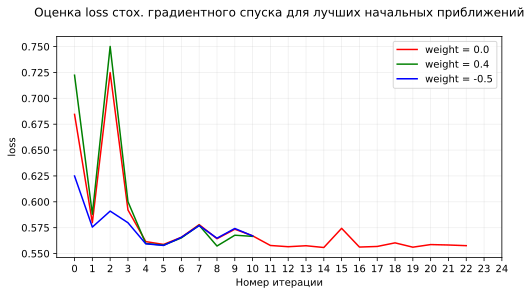

In [115]:
plt.figure(figsize=(8, 4))
plt.title('Оценка loss стох. градиентного спуска для лучших начальных приближений', pad=20)
plt.xlabel('Номер итерации')
plt.ylabel('loss')


plt.plot(np.arange(0, 23, step=1), history_func_w[0.0], 'r', label='weight = 0.0')
plt.plot(np.arange(0, 11, step=1), history_func_w[0.4], 'g', label='weight = 0.4')
plt.plot(np.arange(0, 11, step=1), history_func_w[-0.5], 'b', label='weight = -0.5')
plt.xticks(np.arange(0, 500, step=1))
plt.grid(linestyle="-", alpha=.2)
plt.legend(loc='best')

plt.xlim((-1, 24))
plt.show()

## alpha & beta

In [10]:
alphas = np.arange(1, 5, 1.3)
betas = np.arange(0.1, 0.6, 0.08)

In [11]:
for alpha in alphas:
    alpha = round(alpha, 2)
for beta in betas:
    beta = round(beta, 2)

accuracy_results = {}
for alpha in alphas:
    accuracy_results[round(alpha, 2)] = {}
    for beta in betas:
        accuracy_results[round(alpha, 2)][round(beta, 2)] = []

In [12]:
history_time = {}
history_func = {}
history_weights = {}
for alpha in alphas:
    history_weights[round(alpha, 2)] = {}
    history_time[round(alpha, 2)] = {}
    history_func[round(alpha, 2)] = {}
    for beta in betas:
        history_weights[round(alpha, 2)][round(beta, 2)] = []
        history_time[round(alpha, 2)][round(beta, 2)] = []
        history_func[round(alpha, 2)][round(beta, 2)] = []

In [16]:
w = np.zeros(X_train.shape[1])

for alpha in alphas:
    for beta in betas:
        sgd = SGDClassifier('binary_logistic', step_alpha=alpha, step_beta=beta,
                          l2_coef=0, max_iter=500, batch_size=100)
        
        history = sgd.fit(X_train, y_train, w_0=w, trace=True, log_freq=0.1)
        history_time[round(alpha, 2)][round(beta, 2)] = history['time']
        history_func[round(alpha, 2)][round(beta, 2)] = history['func']
        history_weights[round(alpha, 2)][round(beta, 2)] = history['weights']

### accuracy

In [17]:
for alpha in alphas:
    for beta in betas:
        for weights in history_weights[round(alpha, 2)][round(beta, 2)]:
            y_pred = np.sign(X_valid @ weights)
            accuracy = accuracy_score(y_valid, y_pred)
            accuracy_results[round(alpha, 2)][round(beta, 2)].append(accuracy)

In [18]:
accuracy_results[1]

{0.1: [0.6043407279362335,
  0.6508210890233362,
  0.7275520983386152,
  0.5213675213675214,
  0.7268798617113224,
  0.7436857773936426,
  0.7365792759051186,
  0.5845577643330452,
  0.7434937097858446,
  0.7435897435897436,
  0.7017190050897916,
  0.7408047632766734,
  0.7327379237491597,
  0.7125708249303755,
  0.5584365696725248,
  0.581772784019975,
  0.6144242773456257,
  0.7377316815519063,
  0.7408047632766734,
  0.7463747239028138,
  0.6517814270623259,
  0.7445500816287333,
  0.7298569096321905],
 0.18: [0.6023240180543551,
  0.693268030346682,
  0.7295688082204936,
  0.6119273984442524,
  0.7391721886103909,
  0.7415730337078652,
  0.7317775857101699,
  0.6232593873043312,
  0.7430135407663497,
  0.7458945548833189,
  0.7130509939498704,
  0.7361951406895227,
  0.735138768846634,
  0.728320368769807,
  0.6610006722366273,
  0.6026121194660521,
  0.6874099683088447,
  0.7407087294727744,
  0.7441659464131374],
 0.26: [0.6487083453375588,
  0.7123787573225775,
  0.7356189378661

In [19]:
mean_accuracy_results = {}
for alpha in alphas:
    mean_accuracy_results[round(alpha, 2)] = {}
    for beta in betas:
        mean_accuracy_results[round(alpha, 2)][round(beta, 2)] = []

In [20]:
for alpha in alphas:
    for beta in betas:
        mean_acc = np.mean(accuracy_results[round(alpha, 2)][round(beta, 2)])
        mean_accuracy_results[round(alpha, 2)][round(beta, 2)] = mean_acc

In [21]:
best_betas_for_each_alpha = []
best_acc_list = []

for alpha in alphas:
    curr_best_beta = max(mean_accuracy_results[round(alpha, 2)], key=mean_accuracy_results[round(alpha, 2)].get)
    best_betas_for_each_alpha.append([round(alpha, 2), curr_best_beta, mean_accuracy_results[round(alpha, 2)][curr_best_beta]])
    best_acc_list.append(mean_accuracy_results[round(alpha, 2)][curr_best_beta])
best_betas_for_each_alpha

[[1.0, 0.34, 0.7315562904229246],
 [2.3, 0.5, 0.7197493517718236],
 [3.6, 0.58, 0.7188023517611533],
 [4.9, 0.58, 0.711869778161913]]

In [22]:
best_acc_indexes = sorted(range(len(best_acc_list)), key=lambda x: best_acc_list[x])[-5:]
best_acc_indexes
best_cominations = list(map(lambda x: best_betas_for_each_alpha[x], best_acc_indexes))
best_cominations

[[4.9, 0.58, 0.711869778161913],
 [3.6, 0.58, 0.7188023517611533],
 [2.3, 0.5, 0.7197493517718236],
 [1.0, 0.34, 0.7315562904229246]]

Случай выбора по лучшему среднему значению

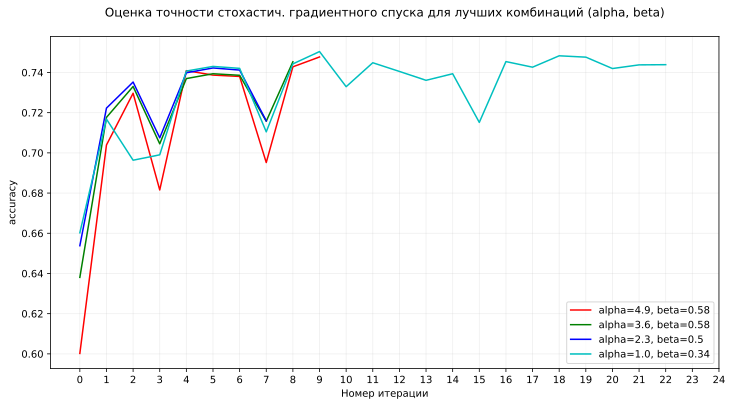

In [28]:
plt.figure(figsize=(12, 6))
plt.title('Оценка точности стохастич. градиентного спуска для лучших комбинаций (alpha, beta)', pad=20)
plt.xlabel('Номер итерации')
plt.ylabel('accuracy')

plt.plot(np.arange(0, 10, step=1), accuracy_results[4.9][0.58], 'r', label='alpha=4.9, beta=0.58')
plt.plot(np.arange(0, 9, step=1), accuracy_results[3.6][0.58], 'g', label='alpha=3.6, beta=0.58')
plt.plot(np.arange(0, 8, step=1), accuracy_results[2.3][0.5], 'b', label='alpha=2.3, beta=0.5')
plt.plot(np.arange(0, 23, step=1), accuracy_results[1.0][0.34], 'c', label='alpha=1.0, beta=0.34')

plt.legend(loc='best')
plt.xticks(np.arange(0, 25, step=1))
plt.grid(linestyle="-", alpha=.2)
#plt.ylim((0.6, 0.8))
#plt.xlim((-1, 10))
plt.show()

Случай выбор по максимальному значению точности

In [29]:
max_accuracy_results = {}
for alpha in alphas:
    max_accuracy_results[round(alpha, 2)] = {}
    for beta in betas:
        max_accuracy_results[round(alpha, 2)][round(beta, 2)] = []

In [30]:
for alpha in alphas:
    for beta in betas:
        max_acc = np.max(accuracy_results[round(alpha, 2)][round(beta, 2)])
        max_accuracy_results[round(alpha, 2)][round(beta, 2)] = max_acc

In [31]:
best_betas_for_each_alpha = []
best_acc_list = []

for alpha in alphas:
    curr_best_beta = max(max_accuracy_results[round(alpha, 2)], key=max_accuracy_results[round(alpha, 2)].get)
    best_betas_for_each_alpha.append([round(alpha, 2), curr_best_beta, max_accuracy_results[round(alpha, 2)][curr_best_beta]])
    best_acc_list.append(max_accuracy_results[round(alpha, 2)][curr_best_beta])

In [32]:
best_acc_indexes = sorted(range(len(best_acc_list)), key=lambda x: best_acc_list[x])[-5:]
best_cominations = list(map(lambda x: best_betas_for_each_alpha[x], best_acc_indexes))
best_cominations

[[1.0, 0.34, 0.7504081436665706],
 [2.3, 0.34, 0.7506002112743686],
 [3.6, 0.34, 0.7509843464899645],
 [4.9, 0.42, 0.752520887352348]]

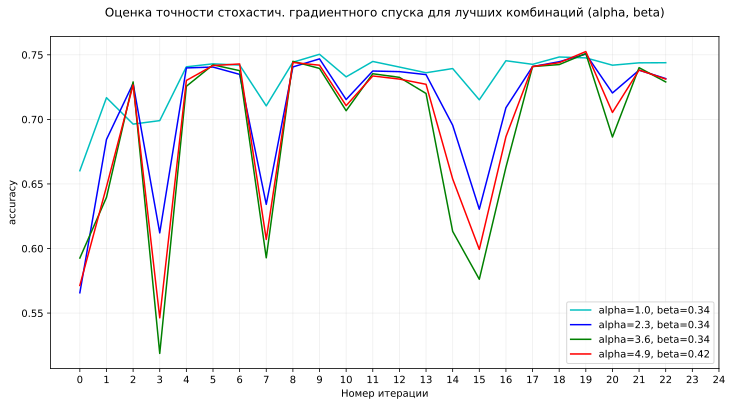

In [53]:
plt.figure(figsize=(12, 6))
plt.title('Оценка точности стохастич. градиентного спуска для лучших комбинаций (alpha, beta)', pad=20)
plt.xlabel('Номер итерации')
plt.ylabel('accuracy')

plt.plot(np.arange(0, 23, step=1), accuracy_results[1.0][0.34], 'c', label='alpha=1.0, beta=0.34')
plt.plot(np.arange(0, 23, step=1), accuracy_results[2.3][0.34], 'b', label='alpha=2.3, beta=0.34')
plt.plot(np.arange(0, 23, step=1), accuracy_results[3.6][0.34], 'g', label='alpha=3.6, beta=0.34')
plt.plot(np.arange(0, 23, step=1), accuracy_results[4.9][0.42], 'r', label='alpha=4.9, beta=0.42')

plt.legend(loc='best')
plt.xticks(np.arange(0, 25, step=1))
plt.grid(linestyle="-", alpha=.2)
#plt.ylim((0.6, 0.8))
#plt.xlim((-1, 10))
plt.show()

### loss

С наименьшим loss

In [38]:
min_loss_results = {}
for alpha in alphas:
    min_loss_results[round(alpha, 2)] = {}
    for beta in betas:
        min_loss_results[round(alpha, 2)][round(beta, 2)] = []

In [39]:
for alpha in alphas:
    for beta in betas:
        min_loss = np.min(history_func[round(alpha, 2)][round(beta, 2)])
        min_loss_results[round(alpha, 2)][round(beta, 2)] = min_loss

In [40]:
best_betas_for_each_alpha = []
best_loss_list = []

for alpha in alphas:
    curr_best_beta = min(min_loss_results[round(alpha, 2)], key=min_loss_results[round(alpha, 2)].get)
    best_betas_for_each_alpha.append([round(alpha, 2), curr_best_beta, min_loss_results[round(alpha, 2)][curr_best_beta]])
    best_loss_list.append(min_loss_results[round(alpha, 2)][curr_best_beta])

In [41]:
best_loss_indexes = sorted(range(len(best_loss_list)), key=lambda x: best_loss_list[x])[:5]
best_loss_indexes
best_cominations = list(map(lambda x: best_betas_for_each_alpha[x], best_loss_indexes))
best_cominations

[[1.0, 0.34, 0.55581778617],
 [2.3, 0.42, 0.558093911009],
 [4.9, 0.5, 0.559729185511],
 [3.6, 0.58, 0.559953020495]]

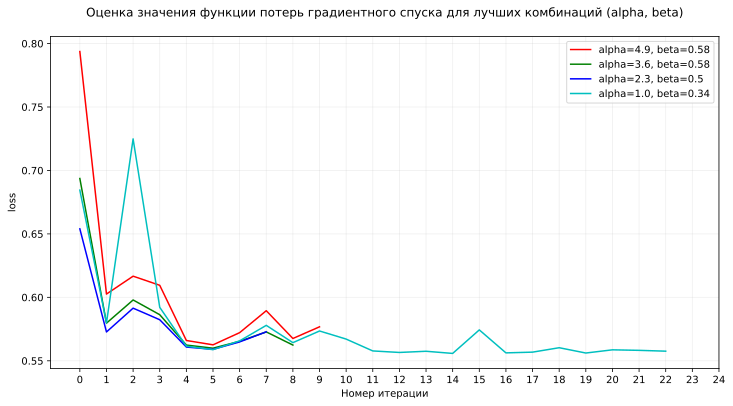

In [42]:
plt.figure(figsize=(12, 6))
plt.title('Оценка значения функции потерь градиентного спуска для лучших комбинаций (alpha, beta)', pad=20)
plt.xlabel('Номер итерации')
plt.ylabel('loss')

plt.plot(np.arange(0, 10, step=1), history_func[4.9][0.58], 'r', label='alpha=4.9, beta=0.58')
plt.plot(np.arange(0, 9, step=1), history_func[3.6][0.58], 'g', label='alpha=3.6, beta=0.58')
plt.plot(np.arange(0, 8, step=1), history_func[2.3][0.5], 'b', label='alpha=2.3, beta=0.5')
plt.plot(np.arange(0, 23, step=1), history_func[1.0][0.34], 'c', label='alpha=1.0, beta=0.34')

plt.legend(loc='best')
plt.xticks(np.arange(0, 25, step=1))
plt.grid(linestyle="-", alpha=.2)
#plt.ylim((0.6, 0.8))
#plt.xlim((-1, 10))
plt.show()

# Experiment 7

In [205]:
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download("stopwords") 
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Авдеев\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Авдеев\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Авдеев\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


#### Data prepare

In [236]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    text = [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]
    lemm_line = ' '.join([w for w in text])
    return lemm_line

In [237]:
data_train['lemm_text'] = data_train['comment_text'].apply(lemmatize_text)
data_test['lemm_text'] = data_test['comment_text'].apply(lemmatize_text)

In [298]:
data_train.insert(4, 'stop_words', 'a')
data_train.insert(4, 'stop_words_no_lemm', 'a')

data_test.insert(4, 'stop_words', 'a')
data_test.insert(4, 'stop_words_no_lemm', 'a')

In [299]:
for i in range(data_train.shape[0]):
    tokens = nltk.word_tokenize(data_train.at[i, 'comment_text'])
    text = [word for word in tokens if word not in stopwords.words('english')]
    lemm_line = ' '.join([w for w in text])
    data_train.at[i, 'stop_words_no_lemm'] = lemm_line

In [300]:
for i in range(data_test.shape[0]):
    tokens = nltk.word_tokenize(data_test.at[i, 'comment_text'])
    text = [word for word in tokens if word not in stopwords.words('english')]
    lemm_line = ' '.join([w for w in text])
    data_test.at[i, 'stop_words_no_lemm'] = lemm_line

In [301]:
for i in range(data_train.shape[0]):
    tokens = nltk.word_tokenize(data_train.at[i, 'lemm_text'])
    text = [word for word in tokens if word not in stopwords.words('english')]
    lemm_line = ' '.join([w for w in text])
    data_train.at[i, 'stop_words'] = lemm_line
    

In [302]:
for i in range(data_test.shape[0]):
    tokens = nltk.word_tokenize(data_test.at[i, 'lemm_text'])
    text = [word for word in tokens if word not in stopwords.words('english')]
    lemm_line = ' '.join([w for w in text])
    data_test.at[i, 'stop_words'] = lemm_line

In [342]:
y_train = np.array(data_train['is_toxic'])

In [343]:
vectorizer  = CountVectorizer(min_df=0.01)
cv_train = vectorizer.fit_transform(data_train['comment_text']).toarray()
cv_train_lemm = vectorizer.fit_transform(data_train['lemm_text']).toarray()
cv_train_stop = vectorizer.fit_transform(data_train['stop_words']).toarray()
cv_train_stop_no_lemm = vectorizer.fit_transform(data_train['stop_words_no_lemm']).toarray()

In [344]:
X_train_clear, X_valid_clear, y_train_clear, y_valid_clear = train_test_split(cv_train, y_train, test_size=0.2, random_state=10)
X_train_lemm, X_valid_lemm, y_train_lemm, y_valid_lemm = train_test_split(cv_train_lemm, y_train, test_size=0.2, random_state=10)
X_train_stop, X_valid_stop, y_train_stop, y_valid_stop = train_test_split(cv_train_stop, y_train, test_size=0.2, random_state=10)
X_train_stop_no_lemm, X_valid_stop_no_lemm, y_train_stop_no_lemm, y_valid_stop_no_lemm = train_test_split(cv_train_stop_no_lemm, y_train, test_size=0.2, random_state=10)

#### stop no lemm

In [346]:
w = np.full(shape=X_train_stop_no_lemm.shape[1], fill_value=0.0, dtype=float)

gd = GDClassifier('binary_logistic', step_alpha=1.0, step_beta=0.34, l2_coef=0, max_iter=500)
        
history = gd.fit(X_train_stop_no_lemm, y_train_stop_no_lemm, w_0=w, trace=True)

history_time_stop_no_lemm = history['time']
history_func_stop_no_lemm = history['func']
history_weights_stop_no_lemm = history['weights']

In [347]:
accuracy_results_stop_no_lemm = []

for weights in history_weights_stop_no_lemm:
    y_pred = np.sign(X_valid_stop_no_lemm @ weights)
    accuracy = accuracy_score(y_valid_stop_no_lemm, y_pred)
    accuracy_results_stop_no_lemm.append(accuracy)

#### lemm

In [350]:
w = np.full(shape=X_train_lemm.shape[1], fill_value=0.0, dtype=float)

gd = GDClassifier('binary_logistic', step_alpha=1.0, step_beta=0.34, l2_coef=0, max_iter=500)
        
history = gd.fit(X_train_lemm, y_train_lemm, w_0=w, trace=True)

history_time_lemm = history['time']
history_func_lemm = history['func']
history_weights_lemm = history['weights']

In [351]:
accuracy_results_lemm = []

for weights in history_weights_lemm:
    y_pred = np.sign(X_valid_lemm @ weights)
    accuracy = accuracy_score(y_valid_lemm, y_pred)
    accuracy_results_lemm.append(accuracy)

#### stop (after lemm)

In [352]:
w = np.full(shape=X_train_stop.shape[1], fill_value=0.0, dtype=float)

gd = GDClassifier('binary_logistic', step_alpha=1.0, step_beta=0.34, l2_coef=0, max_iter=500)
        
history = gd.fit(X_train_stop, y_train_stop, w_0=w, trace=True)

history_time_stop = history['time']
history_func_stop = history['func']
history_weights_stop = history['weights']

In [356]:
accuracy_results_stop = []

for weights in history_weights_stop:
    y_pred = np.sign(X_valid_stop @ weights)
    accuracy = accuracy_score(y_valid_stop, y_pred)
    accuracy_results_stop.append(accuracy)

#### clear data

In [353]:
w = np.full(shape=X_train_clear.shape[1], fill_value=0.0, dtype=float)

gd = GDClassifier('binary_logistic', step_alpha=1.0, step_beta=0.34, l2_coef=0, max_iter=500)
        
history = gd.fit(X_train_clear, y_train_clear, w_0=w, trace=True)

history_time_clear = history['time']
history_func_clear = history['func']
history_weights_clear = history['weights']

In [354]:
accuracy_results_clear = []

for weights in history_weights_clear:
    y_pred = np.sign(X_valid_clear @ weights)
    accuracy = accuracy_score(y_valid_clear, y_pred)
    accuracy_results_clear.append(accuracy)

#### compare accuracy

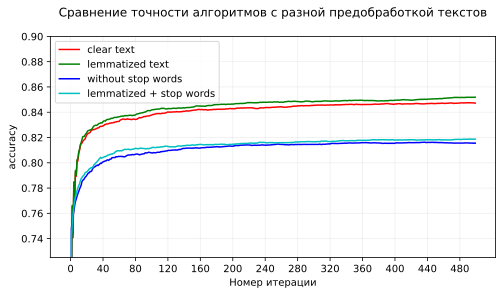

In [382]:
plt.figure(figsize=(8, 4))
plt.title('Сравнение точности алгоритмов с разной предобработкой текстов', pad=20)
plt.xlabel('Номер итерации')
plt.ylabel('accuracy')

plt.plot(np.arange(0, 500, step=1), accuracy_results_clear, 'r', label='clear text')
plt.plot(np.arange(0, 500, step=1), accuracy_results_lemm, 'g', label='lemmatized text')
plt.plot(np.arange(0, 500, step=1), accuracy_results_stop_no_lemm, 'b', label='without stop words')
plt.plot(np.arange(0, 500, step=1), accuracy_results_stop, 'c', label='lemmatized + stop words')

plt.legend(loc='best')
plt.xticks(np.arange(0, 500, step=40))
plt.grid(linestyle="-", alpha=.2)
plt.ylim((0.725, 0.9))
#plt.xlim((-1, 10))
plt.show()

#### compare time

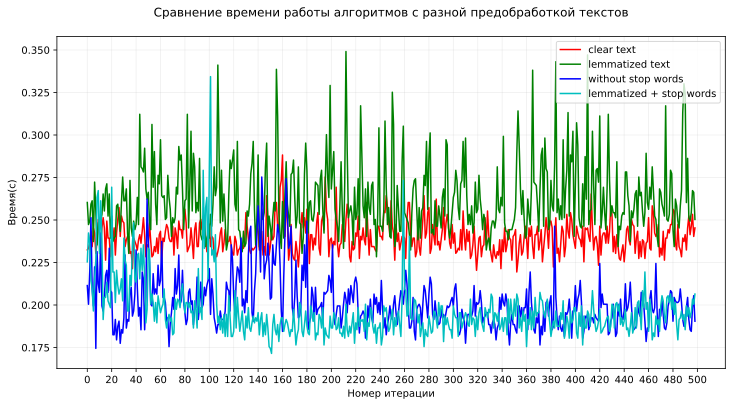

In [365]:
plt.figure(figsize=(12, 6))
plt.title('Сравнение времени работы алгоритмов с разной предобработкой текстов', pad=20)
plt.xlabel('Номер итерации')
plt.ylabel('Время(с)')

plt.plot(np.arange(0, 499, step=1), history_time_clear, 'r', label='clear text')
plt.plot(np.arange(0, 499, step=1), history_time_lemm, 'g', label='lemmatized text')
plt.plot(np.arange(0, 499, step=1), history_time_stop_no_lemm, 'b', label='without stop words')
plt.plot(np.arange(0, 499, step=1), history_time_stop, 'c', label='lemmatized + stop words')

plt.legend(loc='best')
plt.xticks(np.arange(0, 501, step=20))
plt.grid(linestyle="-", alpha=.2)
#plt.ylim((0.6, 0.8))
#plt.xlim((-1, 10))
plt.show()

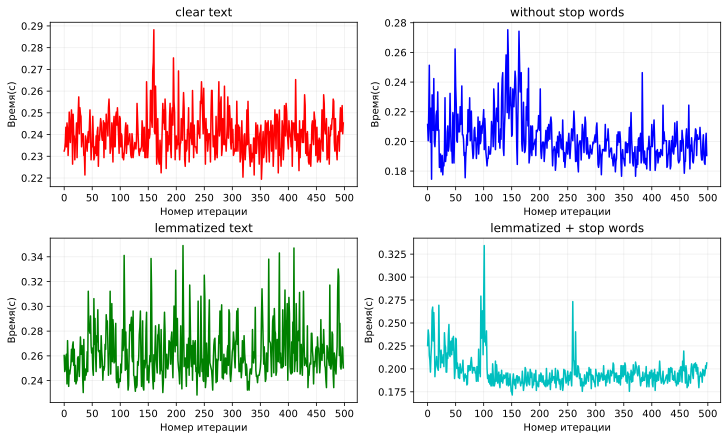

In [372]:
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 6), constrained_layout=True)

ax[0, 0].set_xlabel('Номер итерации')
ax[0, 0].set_ylabel('Время(с)')
ax[0, 0].set_title('clear text')
ax[0, 0].plot(np.arange(0, 499, step=1), history_time_clear, 'r', label='clear text')
ax[0, 0].grid(linestyle="-", alpha=.2)
ax[0, 0].set_xticks(np.arange(0, 501, step=50))

ax[1, 0].set_xlabel('Номер итерации')
ax[1, 0].set_ylabel('Время(с)')
ax[1, 0].set_title('lemmatized text')
ax[1, 0].plot(np.arange(0, 499, step=1), history_time_lemm, 'g', label='lemmatized text')
ax[1, 0].grid(linestyle="-", alpha=.2)
ax[1, 0].set_xticks(np.arange(0, 501, step=50))

ax[0, 1].set_xlabel('Номер итерации')
ax[0, 1].set_ylabel('Время(с)')
ax[0, 1].set_title('without stop words')
ax[0, 1].plot(np.arange(0, 499, step=1), history_time_stop_no_lemm, 'b', label='without stop words')
ax[0, 1].grid(linestyle="-", alpha=.2)
ax[0, 1].set_xticks(np.arange(0, 501, step=50))

ax[1, 1].set_xlabel('Номер итерации')
ax[1, 1].set_ylabel('Время(с)')
ax[1, 1].set_title('lemmatized + stop words')
ax[1, 1].plot(np.arange(0, 499, step=1), history_time_stop, 'c', label='lemmatized + stop words')
ax[1, 1].grid(linestyle="-", alpha=.2)
ax[1, 1].set_xticks(np.arange(0, 501, step=50))

plt.show()

#### feature amount

In [379]:
print('Размерность признакового пространства для очищенного текста: ', cv_train.shape[1])
print('Размерность признакового пространства для лемматизированного текста: ', cv_train_lemm.shape[1])
print('Размерность признакового пространства для лемматизированного текста с удаленными стоп-словами: ', cv_train_stop.shape[1])
print('Размерность признакового пространства для очищенного текста с удаленными стоп-словами: ', cv_train_stop_no_lemm.shape[1])

Размерность признакового пространства для очищенного текста:  568
Размерность признакового пространства для лемматизированного текста:  575
Размерность признакового пространства для лемматизированного текста с удаленными стоп-словами:  457
Размерность признакового пространства для очищенного текста с удаленными стоп-словами:  446


In [407]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i])

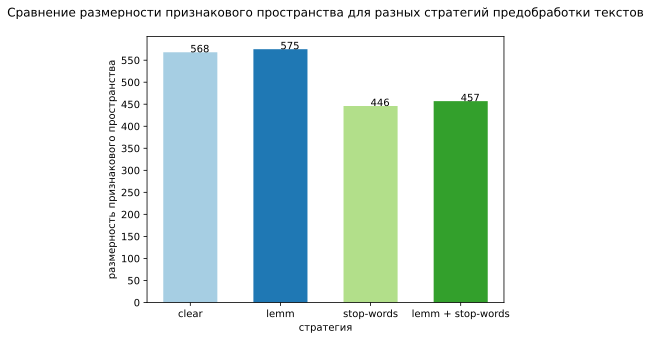

In [408]:
strategies = ['clear', 'lemm', 'stop-words', 'lemm + stop-words']
values = [cv_train.shape[1], cv_train_lemm.shape[1], cv_train_stop_no_lemm.shape[1], cv_train_stop.shape[1]]
col_map = plt.get_cmap('Paired')

plt.bar(strategies, values, color=col_map.colors, width=0.6)
plt.title('Сравнение размерности признакового пространства для разных стратегий предобработки текстов', pad=20)
plt.xlabel('стратегия')
plt.ylabel('размерность признакового пространства')
plt.yticks(np.arange(0, 600, 50))
addlabels(strategies, values)
plt.show()

# Experiment 8

Bag-of-Words vs TF-IDF

In [53]:
min_df_list = np.arange(0.0, 0.5, 0.01)
max_df_list = np.arange(0.5, 1.1, 0.1)

## BoW

In [54]:
history_bow_features = {}
history_bow_acc = {}
history_bow_time = {}

for min_df in min_df_list:
    history_bow_features[round(min_df, 2)]= {}
    history_bow_acc[round(min_df, 2)]= {}
    history_bow_time[round(min_df, 2)]= {}
    for max_df in max_df_list:
        history_bow_features[round(min_df, 2)][round(max_df, 2)] = []
        history_bow_acc[round(min_df, 2)][round(max_df, 2)] = []
        history_bow_time[round(min_df, 2)][round(max_df, 2)] = []

In [55]:
bad_bow_mindf_max_df_combs = []

In [56]:
for min_df in min_df_list:
    for max_df in max_df_list:
        try:
            vectorizer  = CountVectorizer(min_df=min_df, max_df=max_df)
            X_train_bow = vectorizer.fit_transform(data_train['lemm_text']).toarray()
            y_train_bow = np.array(data_train['is_toxic'])
            
            X_train_bow, X_valid_bow, y_train_bow, y_valid_bow = train_test_split(X_train_bow, y_train_bow, test_size=0.2, random_state=10) 
            
            w = np.full(shape=X_train_bow.shape[1], fill_value=0.0, dtype=float)

            gd = GDClassifier('binary_logistic', step_alpha=1.0, step_beta=0.34, l2_coef=0, max_iter=500)
            
            history = gd.fit(X_train_bow, y_train_bow, w_0=w, trace=True)
            
            y_pred = gd.predict(X_valid_bow)
            accuracy = accuracy_score(y_valid_bow, y_pred)
            
            history_bow_features[round(min_df, 2)][round(max_df, 2)] = X_train_bow.shape[1]
            history_bow_acc[round(min_df, 2)][round(max_df, 2)] = accuracy
            history_bow_time[round(min_df, 2)][round(max_df, 2)] = history['time']
        except ValueError:
            bad_bow_mindf_max_df_combs.append((round(min_df, 2), round(max_df, 2)))
        except MemoryError:
            continue

### accuracy

In [299]:
history_bow_features

{0.0: {0.5: [], 0.6: [], 0.7: [], 0.8: [], 0.9: [], 1.0: [], 1.1: []},
 0.01: {0.5: 572, 0.6: 574, 0.7: 575, 0.8: 575, 0.9: 575, 1.0: 575, 1.1: []},
 0.02: {0.5: 296, 0.6: 298, 0.7: 299, 0.8: 299, 0.9: 299, 1.0: 299, 1.1: []},
 0.03: {0.5: 200, 0.6: 202, 0.7: 203, 0.8: 203, 0.9: 203, 1.0: 203, 1.1: []},
 0.04: {0.5: 146, 0.6: 148, 0.7: 149, 0.8: 149, 0.9: 149, 1.0: 149, 1.1: []},
 0.05: {0.5: 108, 0.6: 110, 0.7: 111, 0.8: 111, 0.9: 111, 1.0: 111, 1.1: []},
 0.06: {0.5: 93, 0.6: 95, 0.7: 96, 0.8: 96, 0.9: 96, 1.0: 96, 1.1: []},
 0.07: {0.5: 80, 0.6: 82, 0.7: 83, 0.8: 83, 0.9: 83, 1.0: 83, 1.1: []},
 0.08: {0.5: 69, 0.6: 71, 0.7: 72, 0.8: 72, 0.9: 72, 1.0: 72, 1.1: []},
 0.09: {0.5: 61, 0.6: 63, 0.7: 64, 0.8: 64, 0.9: 64, 1.0: 64, 1.1: []},
 0.1: {0.5: 51, 0.6: 53, 0.7: 54, 0.8: 54, 0.9: 54, 1.0: 54, 1.1: []},
 0.11: {0.5: 45, 0.6: 47, 0.7: 48, 0.8: 48, 0.9: 48, 1.0: 48, 1.1: []},
 0.12: {0.5: 42, 0.6: 44, 0.7: 45, 0.8: 45, 0.9: 45, 1.0: 45, 1.1: []},
 0.13: {0.5: 39, 0.6: 41, 0.7: 42, 0

In [75]:
history_bow_acc

{0.0: {0.5: [], 0.6: [], 0.7: [], 0.8: [], 0.9: [], 1.0: [], 1.1: []},
 0.01: {0.5: 0.8462498799577451,
  0.6: 0.8499951983098051,
  0.7: 0.8518198405838855,
  0.8: 0.8518198405838855,
  0.9: 0.8518198405838855,
  1.0: 0.8518198405838855,
  1.1: []},
 0.02: {0.5: 0.8209929895323154,
  0.6: 0.829155862863728,
  0.7: 0.8304043023144146,
  0.8: 0.8304043023144146,
  0.9: 0.8304043023144146,
  1.0: 0.8304043023144146,
  1.1: []},
 0.03: {0.5: 0.8041870738499952,
  0.6: 0.8162873331412658,
  0.7: 0.8183040430231442,
  0.8: 0.8183040430231442,
  0.9: 0.8183040430231442,
  1.0: 0.8183040430231442,
  1.1: []},
 0.04: {0.5: 0.7893978680495535,
  0.6: 0.8045712090655911,
  0.7: 0.8071641217708634,
  0.8: 0.8071641217708634,
  0.9: 0.8071641217708634,
  1.0: 0.8071641217708634,
  1.1: []},
 0.05: {0.5: 0.7617401325266494,
  0.6: 0.7853644482857965,
  0.7: 0.7863247863247863,
  0.8: 0.7863247863247863,
  0.9: 0.7863247863247863,
  1.0: 0.7863247863247863,
  1.1: []},
 0.06: {0.5: 0.762028233938346

In [68]:
best_min_max_df = []
best_acc_list = []

for min_df in history_bow_acc.keys():
    curr_best_max_df = max(history_bow_acc[round(min_df, 2)], key=history_bow_acc[round(min_df, 2)].get)
    best_min_max_df.append([round(min_df, 2), curr_best_max_df, history_bow_acc[round(min_df, 2)][curr_best_max_df]])
    best_acc_list.append(history_bow_acc[round(min_df, 2)][curr_best_max_df])

C:\Users\Авдеев\AppData\Local\Temp\ipykernel_3984\1505595269.py:5: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  curr_best_max_df = max(history_bow_acc[round(min_df, 2)], key=history_bow_acc[round(min_df, 2)].get)


In [69]:
best_min_max_df

[[0.0, 0.5, []],
 [0.01, 0.7, 0.8518198405838855],
 [0.02, 0.7, 0.8304043023144146],
 [0.03, 0.7, 0.8183040430231442],
 [0.04, 0.7, 0.8071641217708634],
 [0.05, 0.7, 0.7863247863247863],
 [0.06, 0.7, 0.783923941227312],
 [0.07, 0.7, 0.7745126284452127],
 [0.08, 0.7, 0.7720157495438394],
 [0.09, 0.7, 0.769710938250264],
 [0.1, 0.7, 0.7658695860943052],
 [0.11, 0.7, 0.7661576875060021],
 [0.12, 0.7, 0.762796504369538],
 [0.13, 0.7, 0.7614520311149524],
 [0.14, 0.7, 0.7546336310381254],
 [0.15, 0.7, 0.7451262844521271],
 [0.16, 0.7, 0.7438778450014405],
 [0.17, 0.7, 0.7331220589647556],
 [0.18, 0.7, 0.7323537885335638],
 [0.19, 0.7, 0.7291846730048978],
 [0.2, 0.7, 0.7280322673581101],
 [0.21, 0.7, 0.7265917602996255],
 [0.22, 0.7, 0.7194852588111015],
 [0.23, 0.7, 0.7167963123019303],
 [0.24, 0.7, 0.7167963123019303],
 [0.25, 0.7, 0.7167963123019303],
 [0.26, 0.7, 0.7128589263420724],
 [0.27, 0.7, 0.7120906559108806],
 [0.28, 0.7, 0.7089215403822146],
 [0.29, 0.7, 0.7049841544223566],
 [

In [71]:
best_acc_indexes = sorted(range(len(best_acc_list)), key=lambda x: best_acc_list[x])[-6:]
best_min_max_cominations = list(map(lambda x: best_min_max_df[x], best_acc_indexes))
best_min_max_cominations

C:\Users\Авдеев\AppData\Local\Temp\ipykernel_3984\3979663301.py:1: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  best_acc_indexes = sorted(range(len(best_acc_list)), key=lambda x: best_acc_list[x])[-6:]


[[0.05, 0.7, 0.7863247863247863],
 [0.04, 0.7, 0.8071641217708634],
 [0.03, 0.7, 0.8183040430231442],
 [0.02, 0.7, 0.8304043023144146],
 [0.01, 0.7, 0.8518198405838855],
 [0.49, 0.5, []]]

In [76]:
history_bow_acc[0.01]
            

{0.5: 0.8462498799577451,
 0.6: 0.8499951983098051,
 0.7: 0.8518198405838855,
 0.8: 0.8518198405838855,
 0.9: 0.8518198405838855,
 1.0: 0.8518198405838855,
 1.1: []}

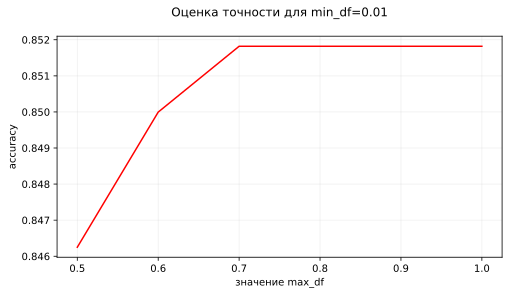

In [81]:

plt.figure(figsize=(8, 4))
plt.title('Оценка точности для min_df=0.01', pad=20)
plt.xlabel('значение max_df')
plt.ylabel('accuracy')

y = [0.8462498799577451, 0.8499951983098051, 0.8518198405838855, 0.8518198405838855, 0.8518198405838855, 0.8518198405838855]
plt.plot(np.arange(0.5, 1.05, 0.1), y, 'r')

plt.grid(linestyle="-", alpha=.2)
plt.show()

In [82]:
history_bow_acc[0.02]

{0.5: 0.8209929895323154,
 0.6: 0.829155862863728,
 0.7: 0.8304043023144146,
 0.8: 0.8304043023144146,
 0.9: 0.8304043023144146,
 1.0: 0.8304043023144146,
 1.1: []}

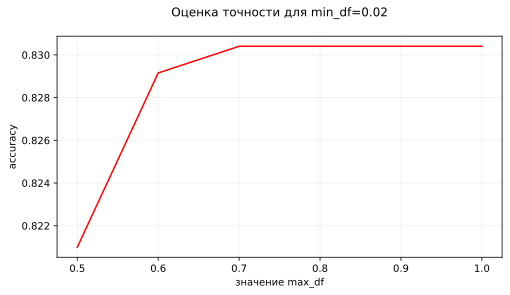

In [83]:
plt.figure(figsize=(8, 4))
plt.title('Оценка точности для min_df=0.02', pad=20)
plt.xlabel('значение max_df')
plt.ylabel('accuracy')

y = [0.8209929895323154, 0.829155862863728, 0.8304043023144146, 0.8304043023144146,  0.8304043023144146, 0.8304043023144146]
plt.plot(np.arange(0.5, 1.05, 0.1), y, 'r')

plt.grid(linestyle="-", alpha=.2)
plt.show()

### time

In [85]:

mean_time_0_01 = {}
for max_df in max_df_list:
    mean_time_0_01[round(max_df, 1)]= []

for max_df in max_df_list:
    mean_acc = np.mean(history_bow_time[0.01][round(max_df, 1)])
    mean_time_0_01[round(max_df, 1)] = mean_acc
mean_time_0_01

c:\lab\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\lab\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{0.5: 0.31225185403842964,
 0.6: 0.29879572061833015,
 0.7: 0.3064175961251727,
 0.8: 0.3093423198363585,
 0.9: 0.30670893646194364,
 1.0: 0.3092607161802854,
 1.1: nan}

In [97]:
mean_time_0_02 = {}
for max_df in max_df_list:
    mean_time_0_02[round(max_df, 1)]= []

for max_df in max_df_list:
    mean_acc = np.mean(history_bow_time[0.02][round(max_df, 1)])
    mean_time_0_02[round(max_df, 1)] = mean_acc
mean_time_0_02

c:\lab\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\lab\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{0.5: 0.16069314522829228,
 0.6: 0.1606473100925973,
 0.7: 0.16220853180589084,
 0.8: 0.1637922465681791,
 0.9: 0.16313253041498646,
 1.0: 0.16216823142133877,
 1.1: nan}

In [101]:
mean_time_0_49 = {}
for max_df in max_df_list:
    mean_time_0_49[round(max_df, 1)]= []

for max_df in max_df_list:
    mean_acc = np.mean(history_bow_time[0.49][round(max_df, 1)])
    mean_time_0_49[round(max_df, 1)] = mean_acc
mean_time_0_49

c:\lab\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\lab\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{0.5: nan,
 0.6: 0.004000258445739746,
 0.7: 0.00533347659640842,
 0.8: 0.0044424401389227975,
 0.9: 0.004449182086520725,
 1.0: 0.00534204641977946,
 1.1: nan}

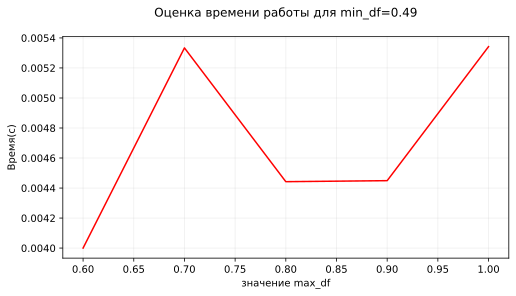

In [102]:
plt.figure(figsize=(8, 4))
plt.title('Оценка времени работы для min_df=0.49', pad=20)
plt.xlabel('значение max_df')
plt.ylabel('Время(с)')

plt.plot(np.arange(0.5, 1.05, 0.1), list(mean_time_0_49.values())[:6], 'r')

plt.grid(linestyle="-", alpha=.2)
plt.show()

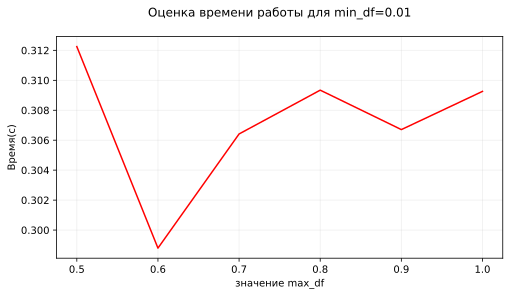

In [96]:
plt.figure(figsize=(8, 4))
plt.title('Оценка времени работы для min_df=0.01', pad=20)
plt.xlabel('значение max_df')
plt.ylabel('Время(с)')

plt.plot(np.arange(0.5, 1.05, 0.1), list(mean_time_0_01.values())[:6], 'r')

plt.grid(linestyle="-", alpha=.2)
plt.show()

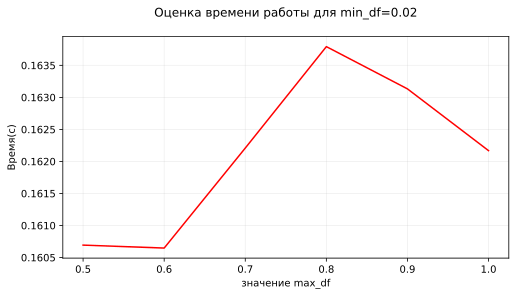

In [98]:
plt.figure(figsize=(8, 4))
plt.title('Оценка времени работы для min_df=0.02', pad=20)
plt.xlabel('значение max_df')
plt.ylabel('Время(с)')

plt.plot(np.arange(0.5, 1.05, 0.1), list(mean_time_0_02.values())[:6], 'r')

plt.grid(linestyle="-", alpha=.2)
plt.show()

## TF-IDF

In [61]:
history_tfidf_features = {}
history_tfidf_acc = {}
history_tfidf_time = {}

for min_df in min_df_list:
    history_tfidf_features[round(min_df, 2)]= {}
    history_tfidf_acc[round(min_df, 2)]= {}
    history_tfidf_time[round(min_df, 2)]= {}
    for max_df in max_df_list:
        history_tfidf_features[round(min_df, 2)][round(max_df, 2)] = []
        history_tfidf_acc[round(min_df, 2)][round(max_df, 2)] = []
        history_tfidf_time[round(min_df, 2)][round(max_df, 2)] = []

In [62]:
bad_tfidf_mindf_max_df_combs = []

In [63]:
for min_df in min_df_list:
    for max_df in max_df_list:
        try:            
            tfidfvectorizor = TfidfVectorizer(min_df=min_df, max_df=max_df)
            X_train_tfidf = tfidfvectorizor.fit_transform(data_train['lemm_text']).toarray()
            y_train_tfidf = np.array(data_train['is_toxic'])
            
            X_train_tfidf, X_valid_tfidf, y_train_tfidf, y_valid_tfidf = train_test_split(X_train_tfidf, y_train_tfidf, test_size=0.2, random_state=10) 
            
            w = np.full(shape=X_train_tfidf.shape[1], fill_value=0.0, dtype=float)

            gd = GDClassifier('binary_logistic', step_alpha=1.0, step_beta=0.34, l2_coef=0, max_iter=500)
            
            history = gd.fit(X_train_tfidf, y_train_tfidf, w_0=w, trace=True)
            
            y_pred = gd.predict(X_valid_tfidf)
            accuracy = accuracy_score(y_valid_bow, y_pred)
            
            history_tfidf_features[round(min_df, 2)][round(max_df, 2)] = X_train_tfidf.shape[1]
            history_tfidf_acc[round(min_df, 2)][round(max_df, 2)] = accuracy
            history_tfidf_time[round(min_df, 2)][round(max_df, 2)] = history['time']
        except ValueError:
            bad_tfidf_mindf_max_df_combs.append((round(min_df, 2), round(max_df, 2)))
        except MemoryError:
            continue

### accuracy

In [300]:
history_tfidf_features

{0.0: {0.5: [], 0.6: [], 0.7: [], 0.8: [], 0.9: [], 1.0: [], 1.1: []},
 0.01: {0.5: 572, 0.6: 574, 0.7: 575, 0.8: 575, 0.9: 575, 1.0: 575, 1.1: []},
 0.02: {0.5: 296, 0.6: 298, 0.7: 299, 0.8: 299, 0.9: 299, 1.0: 299, 1.1: []},
 0.03: {0.5: 200, 0.6: 202, 0.7: 203, 0.8: 203, 0.9: 203, 1.0: 203, 1.1: []},
 0.04: {0.5: 146, 0.6: 148, 0.7: 149, 0.8: 149, 0.9: 149, 1.0: 149, 1.1: []},
 0.05: {0.5: 108, 0.6: 110, 0.7: 111, 0.8: 111, 0.9: 111, 1.0: 111, 1.1: []},
 0.06: {0.5: 93, 0.6: 95, 0.7: 96, 0.8: 96, 0.9: 96, 1.0: 96, 1.1: []},
 0.07: {0.5: 80, 0.6: 82, 0.7: 83, 0.8: 83, 0.9: 83, 1.0: 83, 1.1: []},
 0.08: {0.5: 69, 0.6: 71, 0.7: 72, 0.8: 72, 0.9: 72, 1.0: 72, 1.1: []},
 0.09: {0.5: 61, 0.6: 63, 0.7: 64, 0.8: 64, 0.9: 64, 1.0: 64, 1.1: []},
 0.1: {0.5: 51, 0.6: 53, 0.7: 54, 0.8: 54, 0.9: 54, 1.0: 54, 1.1: []},
 0.11: {0.5: 45, 0.6: 47, 0.7: 48, 0.8: 48, 0.9: 48, 1.0: 48, 1.1: []},
 0.12: {0.5: 42, 0.6: 44, 0.7: 45, 0.8: 45, 0.9: 45, 1.0: 45, 1.1: []},
 0.13: {0.5: 39, 0.6: 41, 0.7: 42, 0

In [64]:
history_tfidf_acc

{0.0: {0.5: [], 0.6: [], 0.7: [], 0.8: [], 0.9: [], 1.0: [], 1.1: []},
 0.01: {0.5: 0.7540574282147315,
  0.6: 0.7668299241332949,
  0.7: 0.766733890329396,
  0.8: 0.766733890329396,
  0.9: 0.766733890329396,
  1.0: 0.766733890329396,
  1.1: []},
 0.02: {0.5: 0.7428214731585518,
  0.6: 0.7611639297032555,
  0.7: 0.7618361663305484,
  0.8: 0.7618361663305484,
  0.9: 0.7618361663305484,
  1.0: 0.7618361663305484,
  1.1: []},
 0.03: {0.5: 0.7389801210025929,
  0.6: 0.7585710169979832,
  0.7: 0.7617401325266494,
  0.8: 0.7617401325266494,
  0.9: 0.7617401325266494,
  1.0: 0.7617401325266494,
  1.1: []},
 0.04: {0.5: 0.7312013828867762,
  0.6: 0.7565543071161048,
  0.7: 0.7587630846057812,
  0.8: 0.7587630846057812,
  0.9: 0.7587630846057812,
  1.0: 0.7587630846057812,
  1.1: []},
 0.05: {0.5: 0.7112263516757898,
  0.6: 0.7437818111975415,
  0.7: 0.7484874675885912,
  0.8: 0.7484874675885912,
  0.9: 0.7484874675885912,
  1.0: 0.7484874675885912,
  1.1: []},
 0.06: {0.5: 0.7100739460290022,


In [103]:
best_min_max_df_tfidf = []
best_acc_list_tfidf = []

for min_df in history_bow_acc.keys():
    curr_best_max_df = max(history_tfidf_acc[round(min_df, 2)], key=history_tfidf_acc[round(min_df, 2)].get)
    best_min_max_df_tfidf.append([round(min_df, 2), curr_best_max_df, history_tfidf_acc[round(min_df, 2)][curr_best_max_df]])
    best_acc_list_tfidf.append(history_tfidf_acc[round(min_df, 2)][curr_best_max_df])
best_min_max_df_tfidf

C:\Users\Авдеев\AppData\Local\Temp\ipykernel_3984\796125580.py:5: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  curr_best_max_df = max(history_tfidf_acc[round(min_df, 2)], key=history_tfidf_acc[round(min_df, 2)].get)


[[0.0, 0.5, []],
 [0.01, 0.6, 0.7668299241332949],
 [0.02, 0.7, 0.7618361663305484],
 [0.03, 0.7, 0.7617401325266494],
 [0.04, 0.7, 0.7587630846057812],
 [0.05, 0.7, 0.7484874675885912],
 [0.06, 0.7, 0.7485835013924902],
 [0.07, 0.7, 0.745702487275521],
 [0.08, 0.7, 0.745606453471622],
 [0.09, 0.7, 0.7450302506482281],
 [0.1, 0.7, 0.7446461154326323],
 [0.11, 0.7, 0.7451262844521271],
 [0.12, 0.7, 0.7425333717468549],
 [0.13, 0.7, 0.742437337942956],
 [0.14, 0.7, 0.7411888984922693],
 [0.15, 0.7, 0.731681551906271],
 [0.16, 0.7, 0.7300489772399885],
 [0.17, 0.7, 0.7243829828099491],
 [0.18, 0.7, 0.7237107461826563],
 [0.19, 0.7, 0.7174685489292231],
 [0.2, 0.7, 0.7175645827331221],
 [0.21, 0.7, 0.7137232305771631],
 [0.22, 0.7, 0.7119946221069816],
 [0.23, 0.7, 0.707384999519831],
 [0.24, 0.7, 0.707384999519831],
 [0.25, 0.7, 0.707384999519831],
 [0.26, 0.7, 0.7055603572457505],
 [0.27, 0.7, 0.7033515797560741],
 [0.28, 0.7, 0.6988379909728224],
 [0.29, 0.7, 0.6981657543455296],
 [0.3,

In [104]:
best_acc_indexes = sorted(range(len(best_acc_list_tfidf)), key=lambda x: best_acc_list_tfidf[x])[-6:]
best_min_max_cominations = list(map(lambda x: best_min_max_df_tfidf[x], best_acc_indexes))
best_min_max_cominations

C:\Users\Авдеев\AppData\Local\Temp\ipykernel_3984\1848585134.py:1: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  best_acc_indexes = sorted(range(len(best_acc_list_tfidf)), key=lambda x: best_acc_list_tfidf[x])[-6:]


[[0.06, 0.7, 0.7485835013924902],
 [0.04, 0.7, 0.7587630846057812],
 [0.03, 0.7, 0.7617401325266494],
 [0.02, 0.7, 0.7618361663305484],
 [0.01, 0.6, 0.7668299241332949],
 [0.49, 0.5, []]]

In [105]:
history_tfidf_acc[0.01]

{0.5: 0.7540574282147315,
 0.6: 0.7668299241332949,
 0.7: 0.766733890329396,
 0.8: 0.766733890329396,
 0.9: 0.766733890329396,
 1.0: 0.766733890329396,
 1.1: []}

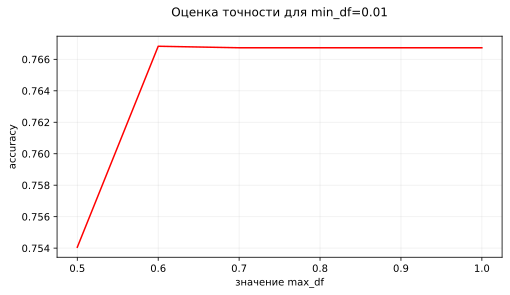

In [106]:
plt.figure(figsize=(8, 4))
plt.title('Оценка точности для min_df=0.01', pad=20)
plt.xlabel('значение max_df')
plt.ylabel('accuracy')

y = [0.7540574282147315, 0.7668299241332949, 0.766733890329396, 0.766733890329396, 0.766733890329396, 0.766733890329396]
plt.plot(np.arange(0.5, 1.05, 0.1), y, 'r')

plt.grid(linestyle="-", alpha=.2)
plt.show()

In [107]:
history_tfidf_acc[0.02]

{0.5: 0.7428214731585518,
 0.6: 0.7611639297032555,
 0.7: 0.7618361663305484,
 0.8: 0.7618361663305484,
 0.9: 0.7618361663305484,
 1.0: 0.7618361663305484,
 1.1: []}

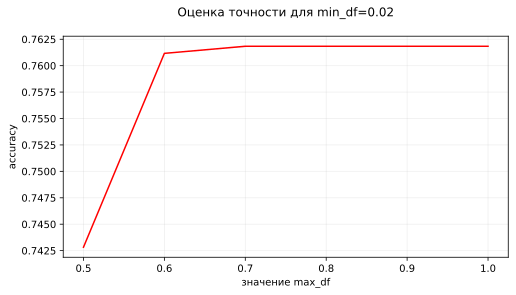

In [108]:
plt.figure(figsize=(8, 4))
plt.title('Оценка точности для min_df=0.02', pad=20)
plt.xlabel('значение max_df')
plt.ylabel('accuracy')

y = [0.7428214731585518, 0.7611639297032555, 0.7618361663305484, 0.7618361663305484, 0.7618361663305484, 0.7618361663305484]
plt.plot(np.arange(0.5, 1.05, 0.1), y, 'r')

plt.grid(linestyle="-", alpha=.2)
plt.show()

### time

In [109]:
mean_time_0_01 = {}
for max_df in max_df_list:
    mean_time_0_01[round(max_df, 1)]= []

for max_df in max_df_list:
    mean_acc = np.mean(history_tfidf_time[0.01][round(max_df, 1)])
    mean_time_0_01[round(max_df, 1)] = mean_acc
mean_time_0_01

c:\lab\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\lab\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{0.5: 0.12716879586657445,
 0.6: 0.12001298806949226,
 0.7: 0.117049148421966,
 0.8: 0.11166034862847032,
 0.9: 0.12314970507650433,
 1.0: 0.1156553242631809,
 1.1: nan}

In [111]:
mean_time_0_02 = {}
for max_df in max_df_list:
    mean_time_0_02[round(max_df, 1)]= []

for max_df in max_df_list:
    mean_acc = np.mean(history_tfidf_time[0.02][round(max_df, 1)])
    mean_time_0_02[round(max_df, 1)] = mean_acc
mean_time_0_02

c:\lab\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\lab\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{0.5: 0.06076332323536844,
 0.6: 0.06228230281439955,
 0.7: 0.0657612011284532,
 0.8: 0.06204246136850728,
 0.9: 0.06195205915905908,
 1.0: 0.06787696773399093,
 1.1: nan}

In [114]:
mean_time_0_49 = {}
for max_df in max_df_list:
    mean_time_0_49[round(max_df, 1)]= []

for max_df in max_df_list:
    mean_acc = np.mean(history_tfidf_time[0.49][round(max_df, 1)])
    mean_time_0_49[round(max_df, 1)] = mean_acc
mean_time_0_49

c:\lab\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\lab\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{0.5: nan,
 0.6: 0.003374813783048379,
 0.7: 0.00356961985429128,
 0.8: 0.0032995025316874186,
 0.9: 0.0033576895793279013,
 1.0: 0.003511437773704529,
 1.1: nan}

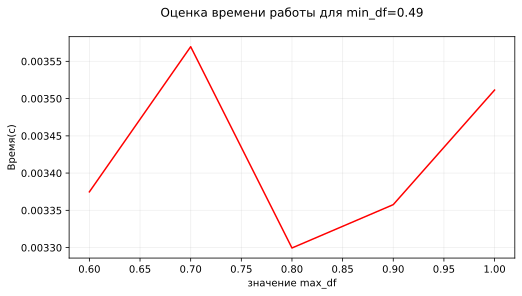

In [115]:
plt.figure(figsize=(8, 4))
plt.title('Оценка времени работы для min_df=0.49', pad=20)
plt.xlabel('значение max_df')
plt.ylabel('Время(с)')

plt.plot(np.arange(0.5, 1.05, 0.1), list(mean_time_0_49.values())[:6], 'r')

plt.grid(linestyle="-", alpha=.2)
plt.show()

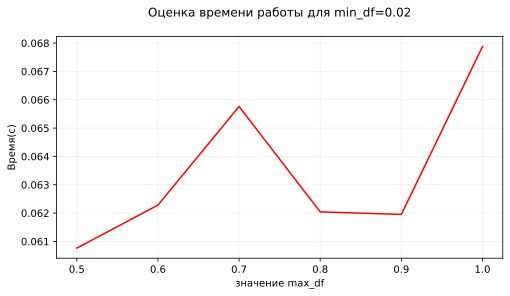

In [113]:
plt.figure(figsize=(8, 4))
plt.title('Оценка времени работы для min_df=0.02', pad=20)
plt.xlabel('значение max_df')
plt.ylabel('Время(с)')

plt.plot(np.arange(0.5, 1.05, 0.1), list(mean_time_0_02.values())[:6], 'r')

plt.grid(linestyle="-", alpha=.2)
plt.show()

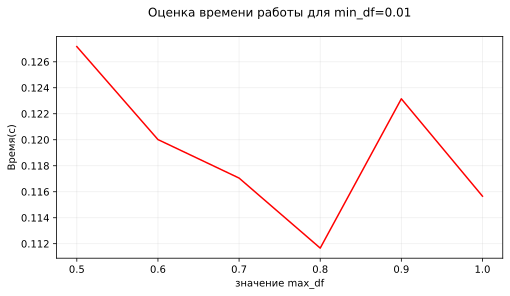

In [110]:
plt.figure(figsize=(8, 4))
plt.title('Оценка времени работы для min_df=0.01', pad=20)
plt.xlabel('значение max_df')
plt.ylabel('Время(с)')

plt.plot(np.arange(0.5, 1.05, 0.1), list(mean_time_0_01.values())[:6], 'r')

plt.grid(linestyle="-", alpha=.2)
plt.show()

# Experiment 9

In [238]:
vectorizer = CountVectorizer(min_df=0.01, max_df=0.9)
cv_train = vectorizer.fit_transform(data_train['lemm_text']).toarray()
cv_test = vectorizer.transform(data_test['lemm_text']).toarray()

In [239]:
data_test.at[16, 'lemm_text']

'일이삼사오육칠팔구하고십이요 에헤헤 으헤 으헤 으허허'

In [240]:
X_train = cv_train
y_train = np.array(data_train['is_toxic'])
X_test = cv_test
y_test = np.array(data_test['is_toxic'])

In [241]:
w = np.full(shape=X_train.shape[1], fill_value=0.0, dtype=float)

gd = GDClassifier('binary_logistic', step_alpha=1.0, step_beta=0.34, l2_coef=0, max_iter=1000)
        
history = gd.fit(X_train, y_train, w_0=w, trace=True)

In [242]:
len(np.where(~X_test.any(axis=1))[0])
    

530

In [248]:
np.where(~X_test.any(axis=1))[0]

array([   16,    30,    39,    54,    60,   162,   187,   246,   297,
         300,   332,   390,   393,   449,   463,   468,   488,   508,
         546,   629,   657,   659,   724,   745,   755,   776,   803,
         858,   885,   960,   974,  1001,  1044,  1070,  1132,  1155,
        1167,  1181,  1316,  1393,  1434,  1462,  1490,  1636,  1664,
        1684,  1722,  1726,  1734,  1754,  1767,  1868,  1921,  1931,
        1992,  2046,  2113,  2133,  2135,  2174,  2183,  2197,  2230,
        2277,  2287,  2319,  2327,  2348,  2359,  2374,  2393,  2487,
        2550,  2574,  2593,  2678,  2699,  2808,  2855,  2927,  2969,
        3031,  3046,  3113,  3162,  3207,  3235,  3273,  3305,  3349,
        3389,  3407,  3416,  3427,  3435,  3451,  3502,  3528,  3551,
        3557,  3563,  3613,  3621,  3693,  3760,  3771,  3796,  3868,
        3988,  3996,  4007,  4009,  4025,  4101,  4127,  4148,  4242,
        4366,  4367,  4450,  4513,  4519,  4542,  4543,  4580,  4587,
        4589,  4611,

In [243]:
y_pred = gd.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

In [244]:
np.unique (y_pred)

array([-1.,  0.,  1.])

In [245]:
print('Точность модели:', accuracy)

Точность модели: 0.8105532985103502


In [246]:
cm = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred))

In [250]:
data_test['is_toxic'].value_counts()

-1    14433
 1     6243
Name: is_toxic, dtype: int64

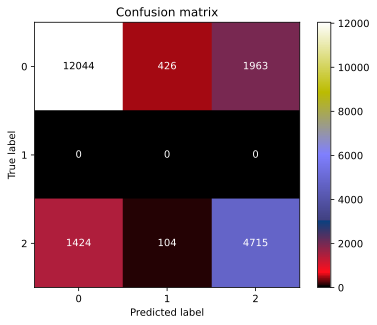

In [247]:
colors = ['gist_stern']
for col in colors:
    cm.plot(cmap=col)
    plt.title('Confusion matrix')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

In [254]:
errors0_2 = []
errors2_0 = []
for i in range(len(y_pred)):
    if y_pred[i] == -1 and y_test[i] == 1:
        errors0_2.append(i)
    elif y_pred[i] == 1 and y_test[i] == -1:
        errors2_0.append(i)

In [260]:
for i in errors2_0:
    print(data_test.at[i, 'comment_text'])
    print('-------------')

dear god this site is horrible
-------------
jews are not a race because you can only get it from your mother your own mention of ethiopian jews not testing as jews proves it is not as well as the fact that we accept converts
-------------
i will burn you to hell if you revoke my talk page access
-------------
brandonyusoftoropov has requested mediation over a conflict with you ed user brandonyusoftoropov brandonyusoftoropov has requested mediation over a conflict with you i am willing to mediate the dispute do you accept if so please end me an email at pgunn dachte org
-------------
avg plenty of greeks love the king stop acting like all greeks hate him you just parrot what the government tells us via their media we greeks asked george i to be our king we supported them they reclaimed much of our lands we voted to keep them numerous times in the 1930 s by 97 vote also he tried to overthrow the dictators read a book the greek government is the biggest liars the us didn t want us to hav

In [261]:
for i in errors0_2:
    print(data_test.at[i, 'comment_text'])
    print('-------------')

arabs are committing genocide in iraq but no protests in europe may europe also burn in hell
-------------
eek but shes cute in an earthy kind of way cant sing for shit though thanks for giving me an unhappy memory
-------------
well it sucks to have a university to be nicknameless and it s the first time in ncaa history that it has happened
-------------
so on the tenth anniversary of 9 11 new york times columnist paul krugman delivered the odious piece of dribble ever on the attack well at least since the last time he wrote about it the headline is quote the years of shame end quote and no it s not directed at radical islam instead he targets america and the quote fake heroes krugman claims that the atrocity has been hijacked the sick word given that he s not actually talking about the real hijackers who killed some 3 000 americans no he s referring to people like george bush and rudy giuliani who he thinks capitalized on the horrible crimes but the worst part at the end of this colu

# Bonus

## bigrams

In [285]:
vectorizer = CountVectorizer(min_df=0.01, ngram_range=(1,2))
cv_train = vectorizer.fit_transform(data_train['lemm_text']).toarray()
cv_test = vectorizer.transform(data_test['lemm_text']).toarray()

In [287]:
w = np.full(shape=cv_test.shape[1], fill_value=0.0, dtype=float)

gd = GDClassifier('binary_logistic', step_alpha=1.0, step_beta=0.34, l2_coef=0, max_iter=1000)
        
history = gd.fit(cv_train, y_train, w_0=w, trace=True)

history_time_lemm = history['time']
history_func_lemm = history['func']
history_weights_lemm = history['weights']

In [288]:
y_pred = gd.predict(cv_test)
accuracy = accuracy_score(y_test, y_pred)
print('Точность модели:', accuracy)

Точность модели: 0.8123911781775972


## trigrams

In [289]:
vectorizer = CountVectorizer(min_df=0.01, ngram_range=(1,3))
cv_train_tri = vectorizer.fit_transform(data_train['lemm_text']).toarray()
cv_test_tri = vectorizer.transform(data_test['lemm_text']).toarray()

In [292]:
w = np.full(shape=cv_train_tri.shape[1], fill_value=0.0, dtype=float)

gd_tri = GDClassifier('binary_logistic', step_alpha=1.0, step_beta=0.34, l2_coef=0, max_iter=1000)
        
history_tri = gd_tri.fit(cv_train_tri, y_train, w_0=w, trace=True)

history_time_lemm_tri = history_tri['time']
history_func_lemm_tri = history_tri['func']
history_weights_lemm_tri = history_tri['weights']

In [293]:
y_pred_tri = gd_tri.predict(cv_test_tri)
accuracy = accuracy_score(y_test, y_pred_tri)
print('Точность модели:', accuracy)

Точность модели: 0.8121009866511898


## 4grams

In [294]:
vectorizer = CountVectorizer(min_df=0.01, ngram_range=(1,4))
cv_train_4 = vectorizer.fit_transform(data_train['lemm_text']).toarray()
cv_test_4 = vectorizer.transform(data_test['lemm_text']).toarray()

In [295]:
w = np.full(shape=cv_train_4.shape[1], fill_value=0.0, dtype=float)

gd_4 = GDClassifier('binary_logistic', step_alpha=1.0, step_beta=0.34, l2_coef=0, max_iter=1000)
        
history_4 = gd_4.fit(cv_train_4, y_train, w_0=w, trace=True)

history_time_lemm_tri = history_tri['time']
history_func_lemm_tri = history_tri['func']
history_weights_lemm_tri = history_tri['weights']

In [297]:
y_pred_4 = gd_4.predict(cv_test_4)
accuracy = accuracy_score(y_test, y_pred_4)
print('Точность модели:', accuracy)


Точность модели: 0.8121009866511898
